# 澳大利亚天气数据和降雨预测

数据分析报告

任务分工：
1. Part1 郑天尧 20307100058
2. Part2 何兼良 20307100010
3. Part3 周霁稼 20307100030

---

# 研究的主要问题：
1. 澳大利亚不同地区的天气情况
2. 不同天气因素对降雨的影响
3. 应用时间序列分析模型对降雨预测
4. 应用其他机器学习模型对降雨预测
5. 一些其他问题的探究

---

# 数据集介绍

本报告的数据集来自于Kaggle网站，名称为"Rain in Australia"，网址为https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package 。数据集包括了近十年以来澳大利亚各个地区的降雨情况以及一些可能的影响因素的数据。该数据集的处理目标是预测一个二元变量 RainTomorrow，即明天是否会下雨。原数据集的文件为 weatherAUS.csv这一数据集。下面会对该数据集进行介绍和分析。

## weatherAUS

<p style="line-height:2">
    数据集文件为澳大利亚各个地区降雨的时间序列数据，时间跨度为 2008 年 12 月 1 日至 2017 年 6 月 25 日，共有 145461 条记录。数据表包括二十三个字段: Date、Location、MinTemp、MaxTemp、Evaporation、Sunshine、Rainfall、WindGustDir、WindGustSpeed、WindDir9am、WindDir3pm、WindSpeed9am、WindSpeed3pm、Humidity9am、Humidity3pm、Pressure9am、Pressure3pm、Temp9am、Temp3pm、RainToday、RainTomorrow，字段含义如下表所示。
</p>

|字段|含义|
|:-|:-|
|Date|日期|
|Location|地点|
|MinTemp|最低温度|
|MaxTemp|最高温度|
|Evaporation|当天蒸发量|
|Sunshine|当天总日照时长|
|Rainfall|当天总降雨量|
|Sunshine|当天总日照时长|
|WindGustDir|当天最强（主要）风向|
|WindGustSpeed|当天最强（主要）风向的平均风速大小|
|WindDir9am|当天早上9点钟的风向|
|WindDir3am|当天下午3点钟的风向|
|WindSpeed9am|当天早上9点钟的风速|
|WindSpeed3pm|当天下午3点钟的风速|
|Humidity9am|当天早上9点钟的湿度|
|Humidity3pm|当天下午3点钟的湿度|
|Pressure9am|当天早上9点钟的气压|
|Pressure3pm|当天下午3点钟的气压|
|Temp9am|当天早上9点钟的温度|
|Temp3pm|当天下午3点钟的温度|
|RainToday|当天是否下雨|
|RainTomorrow|第二天是否下雨|

In [86]:
# 导入所需要的库
import pandas as pd
import numpy as np 
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import statsmodels.api as sm
import shap

import tensorflow as tf
import warnings

from matplotlib.patches import Circle

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression,LogisticRegression,Perceptron
from sklearn import linear_model,manifold
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error,accuracy_score,confusion_matrix,roc_curve,roc_auc_score,f1_score,recall_score

from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler,label_binarize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.manifold import SpectralEmbedding,TSNE

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from scipy import stats

# 忽略所有警告
warnings.filterwarnings("ignore")

---

# Part1 数据预处理和数据探索性分析

# 数据导入和预处理

In [2]:
# 导入数据
df = pd.read_csv('weatherAUS.csv')
df.head()

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008/12/1   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008/12/2   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008/12/3   Albury     12.9     25.7       0.0          NaN       NaN   
3  2008/12/4   Albury      9.2     28.0       0.0          NaN       NaN   
4  2008/12/5   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  Humidity3pm  \
0           W           44.0          W  ...        71.0         22.0   
1         WNW           44.0        NNW  ...        44.0         25.0   
2         WSW           46.0          W  ...        38.0         30.0   
3          NE           24.0         SE  ...        45.0         16.0   
4           W           41.0        ENE  ...        82.0         33.0   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
0       1007.7       1007.1       8.0       NaN     16.9     21.8         No   
1       1010.6       1007.8       NaN       NaN     17.2     24.3         No   
2       1007.6       1008.7       NaN       2.0     21.0     23.2         No   
3       1017.6       1012.8       NaN       NaN     18.1     26.5         No   
4       1010.8       1006.0       7.0       8.0     17.8     29.7         No   

   RainTomorrow  
0            No  
1            No  
2            No  
3            No  
4            No  

[5 rows x 23 columns]

In [3]:
# 删去缺失值超过20%的列
# 计算每列的缺失值比例
missing_percentage = df.isnull().mean()
columns_to_drop = missing_percentage[missing_percentage > 0.2].index
df = df.drop(columns_to_drop, axis=1)
df = df.replace({'Yes': 1, 'No': 0}) 
# 对于连续数字的行，用移动平均代替缺失值
df_mathcolumns = ['MinTemp', 'MaxTemp', 'Rainfall','WindGustSpeed', 'WindSpeed9am','WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am','Pressure3pm', 'Temp9am', 'Temp3pm']
for column in df_mathcolumns:
    if df[column].isnull().sum() > 0:
        column_mean = df[column].head(5).mean()  # 取前五行的平均值
        df[column].fillna(column_mean, inplace=True)
# 最终去除剩下还有缺失值的行
df_new = df.dropna()
df_new.head()

Date Location  MinTemp  MaxTemp  Rainfall WindGustDir  WindGustSpeed  \
0  2008/12/1   Albury     13.4     22.9       0.6           W           44.0   
1  2008/12/2   Albury      7.4     25.1       0.0         WNW           44.0   
2  2008/12/3   Albury     12.9     25.7       0.0         WSW           46.0   
3  2008/12/4   Albury      9.2     28.0       0.0          NE           24.0   
4  2008/12/5   Albury     17.5     32.3       1.0           W           41.0   

  WindDir9am WindDir3pm  WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  \
0          W        WNW          20.0          24.0         71.0         22.0   
1        NNW        WSW           4.0          22.0         44.0         25.0   
2          W        WSW          19.0          26.0         38.0         30.0   
3         SE          E          11.0           9.0         45.0         16.0   
4        ENE         NW           7.0          20.0         82.0         33.0   

   Pressure9am  Pressure3pm  Temp9am  Temp3pm  RainToday  RainTomorrow  
0       1007.7       1007.1     16.9     21.8        0.0           0.0  
1       1010.6       1007.8     17.2     24.3        0.0           0.0  
2       1007.6       1008.7     21.0     23.2        0.0           0.0  
3       1017.6       1012.8     18.1     26.5        0.0           0.0  
4       1010.8       1006.0     17.8     29.7        0.0           0.0

# 地区性分析

在本小节，我们初步探索了不同地区降雨量、温度、湿度、气压、风向风速等天气特性，对于澳大利亚不同地区的天气情况和季节性情况有了基本认识，为后续的探索研究做了铺垫

<strong>降水量情况</strong>

In [4]:
#各地区降雨量描述性统计
df_new.groupby('Location')['Rainfall'].describe()

count      mean        std  min  25%  50%  75%    max
Location                                                                
Adelaide          2746.0  1.632265   4.698055  0.0  0.0  0.0  0.8   75.2
Albury            2445.0  2.190593   6.729338  0.0  0.0  0.0  0.8  104.2
AliceSprings      2748.0  0.921252   4.566314  0.0  0.0  0.0  0.0   62.0
BadgerysCreek     2458.0  2.374614   7.679121  0.0  0.0  0.0  0.6  116.0
Ballarat          2895.0  1.703627   4.729011  0.0  0.0  0.0  1.2   58.6
Bendigo           2725.0  1.713688   5.345074  0.0  0.0  0.0  0.4   66.4
Brisbane          3029.0  3.039353  11.271267  0.0  0.0  0.0  0.6  182.6
Cairns            2900.0  5.683931  18.347382  0.0  0.0  0.0  2.6  278.4
Canberra          2762.0  1.865025   5.954444  0.0  0.0  0.0  0.2   87.0
Cobar             2925.0  1.135658   4.439821  0.0  0.0  0.0  0.0   68.0
CoffsHarbour      2568.0  5.056153  16.362385  0.0  0.0  0.0  2.2  219.6
Dartmoor          2418.0  2.378329   5.304178  0.0  0.0  0.2  2.2   73.6
Darwin            3119.0  5.024944  16.499730  0.0  0.0  0.0  1.6  367.6
GoldCoast         2832.0  3.666879  12.738109  0.0  0.0  0.0  1.2  183.4
Hobart            3106.0  1.618287   4.445060  0.0  0.0  0.0  1.0   71.6
Katherine         1473.0  3.144942  11.467161  0.0  0.0  0.0  0.0  167.0
Launceston        2503.0  2.224091   5.756515  0.0  0.0  0.0  1.0   88.0
Melbourne         2240.0  1.845446   5.231108  0.0  0.0  0.0  1.2   82.2
MelbourneAirport  2943.0  1.469521   4.637238  0.0  0.0  0.0  0.8   75.8
Mildura           2903.0  0.952842   5.076497  0.0  0.0  0.0  0.0  155.0
Moree             2635.0  1.611917   6.622400  0.0  0.0  0.0  0.0  113.0
MountGambier      2898.0  2.109248   5.232888  0.0  0.0  0.2  1.8   84.6
MountGinini       2524.0  3.229556   9.052466  0.0  0.0  0.0  1.6  107.6
Nhil              1518.0  0.953623   3.292589  0.0  0.0  0.0  0.2   65.6
NorahHead         2790.0  3.445663   9.515372  0.0  0.0  0.0  1.6  126.4
NorfolkIsland     2868.0  3.156695   9.758781  0.0  0.0  0.2  1.8  156.8
Nuriootpa         2812.0  1.397937   4.437507  0.0  0.0  0.0  0.4   76.6
PearceRAAF        2469.0  1.620859   5.295411  0.0  0.0  0.0  0.0   62.4
Penrith           2366.0  2.365173   7.696459  0.0  0.0  0.0  0.6  115.4
Perth             3049.0  1.839029   5.710104  0.0  0.0  0.0  0.2  114.4
PerthAirport      2924.0  1.736936   5.289725  0.0  0.0  0.0  0.2   76.6
Portland          2890.0  2.547543   5.563690  0.0  0.0  0.2  2.6   72.0
Richmond          2073.0  2.555909   8.171362  0.0  0.0  0.0  0.6  113.4
Sale              2771.0  1.555215   4.577085  0.0  0.0  0.0  0.8   55.6
SalmonGums        2865.0  1.035462   3.706905  0.0  0.0  0.0  0.2   55.4
Sydney            2285.0  3.495492  10.497717  0.0  0.0  0.0  1.4  119.4
SydneyAirport     2941.0  2.976199   9.141456  0.0  0.0  0.0  1.2  106.8
Townsville        2884.0  3.441193  14.901225  0.0  0.0  0.0  0.2  236.8
Tuggeranong       2322.0  2.339621   7.764706  0.0  0.0  0.0  0.4   93.0
Uluru             1446.0  0.721577   4.250895  0.0  0.0  0.0  0.0   83.8
WaggaWagga        2801.0  1.740378   6.023658  0.0  0.0  0.0  0.2  110.8
Walpole           2506.0  2.909816   6.406086  0.0  0.0  0.2  2.2   93.2
Watsonia          2745.0  1.859162   5.295003  0.0  0.0  0.0  1.0   84.0
Williamtown       2203.0  3.579256  12.173489  0.0  0.0  0.0  1.4  225.0
Witchcliffe       2653.0  2.971052   7.523147  0.0  0.0  0.0  2.0   99.4
Wollongong        2817.0  3.647284  11.973068  0.0  0.0  0.0  1.0  192.0
Woomera           2917.0  0.496743   2.759541  0.0  0.0  0.0  0.0   66.4

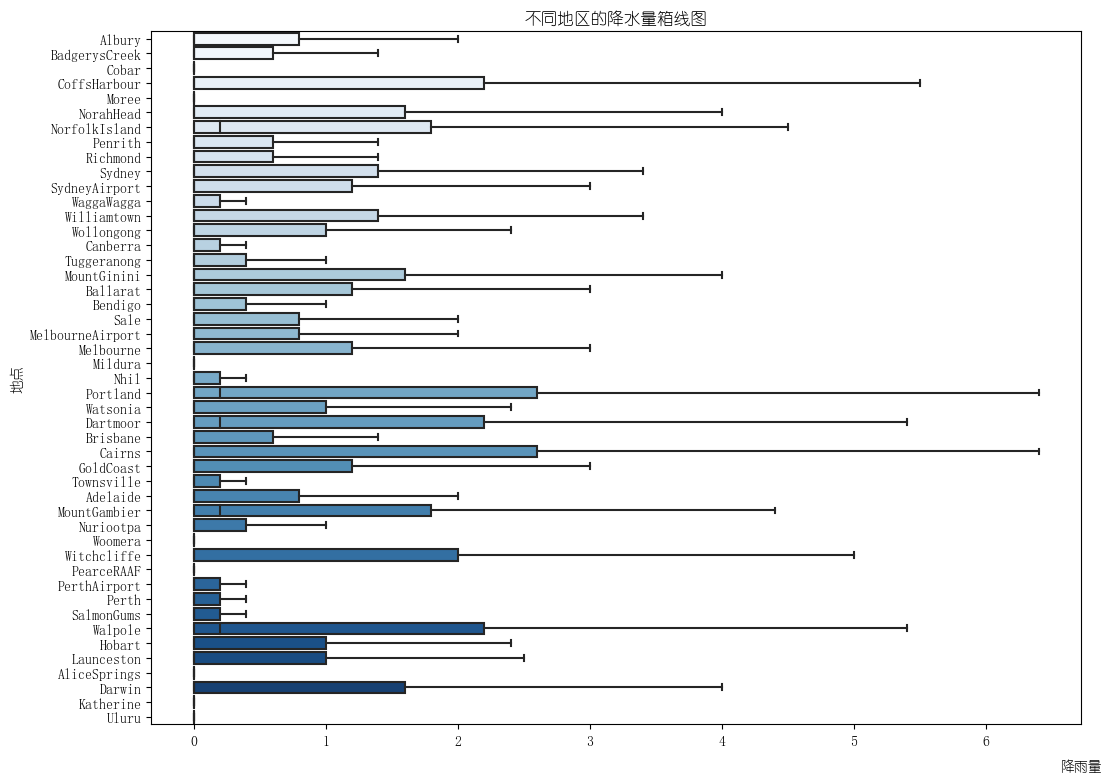

In [5]:
# 绘制不同地区降雨量的箱线图
matplotlib.rc("font",family='YouYuan')

fig, ax = plt.subplots(figsize=(12, 9))
fig = sns.boxplot(x="Rainfall", y="Location", data=df_new, showfliers=False, palette="Blues")
ax.set(xlabel="降雨量", ylabel="地点", title="不同地区的降水量箱线图")
ax.xaxis.set_label_coords(1, -0.05)
plt.show()

<strong> 降水量变化趋势:代表性城市 </strong>

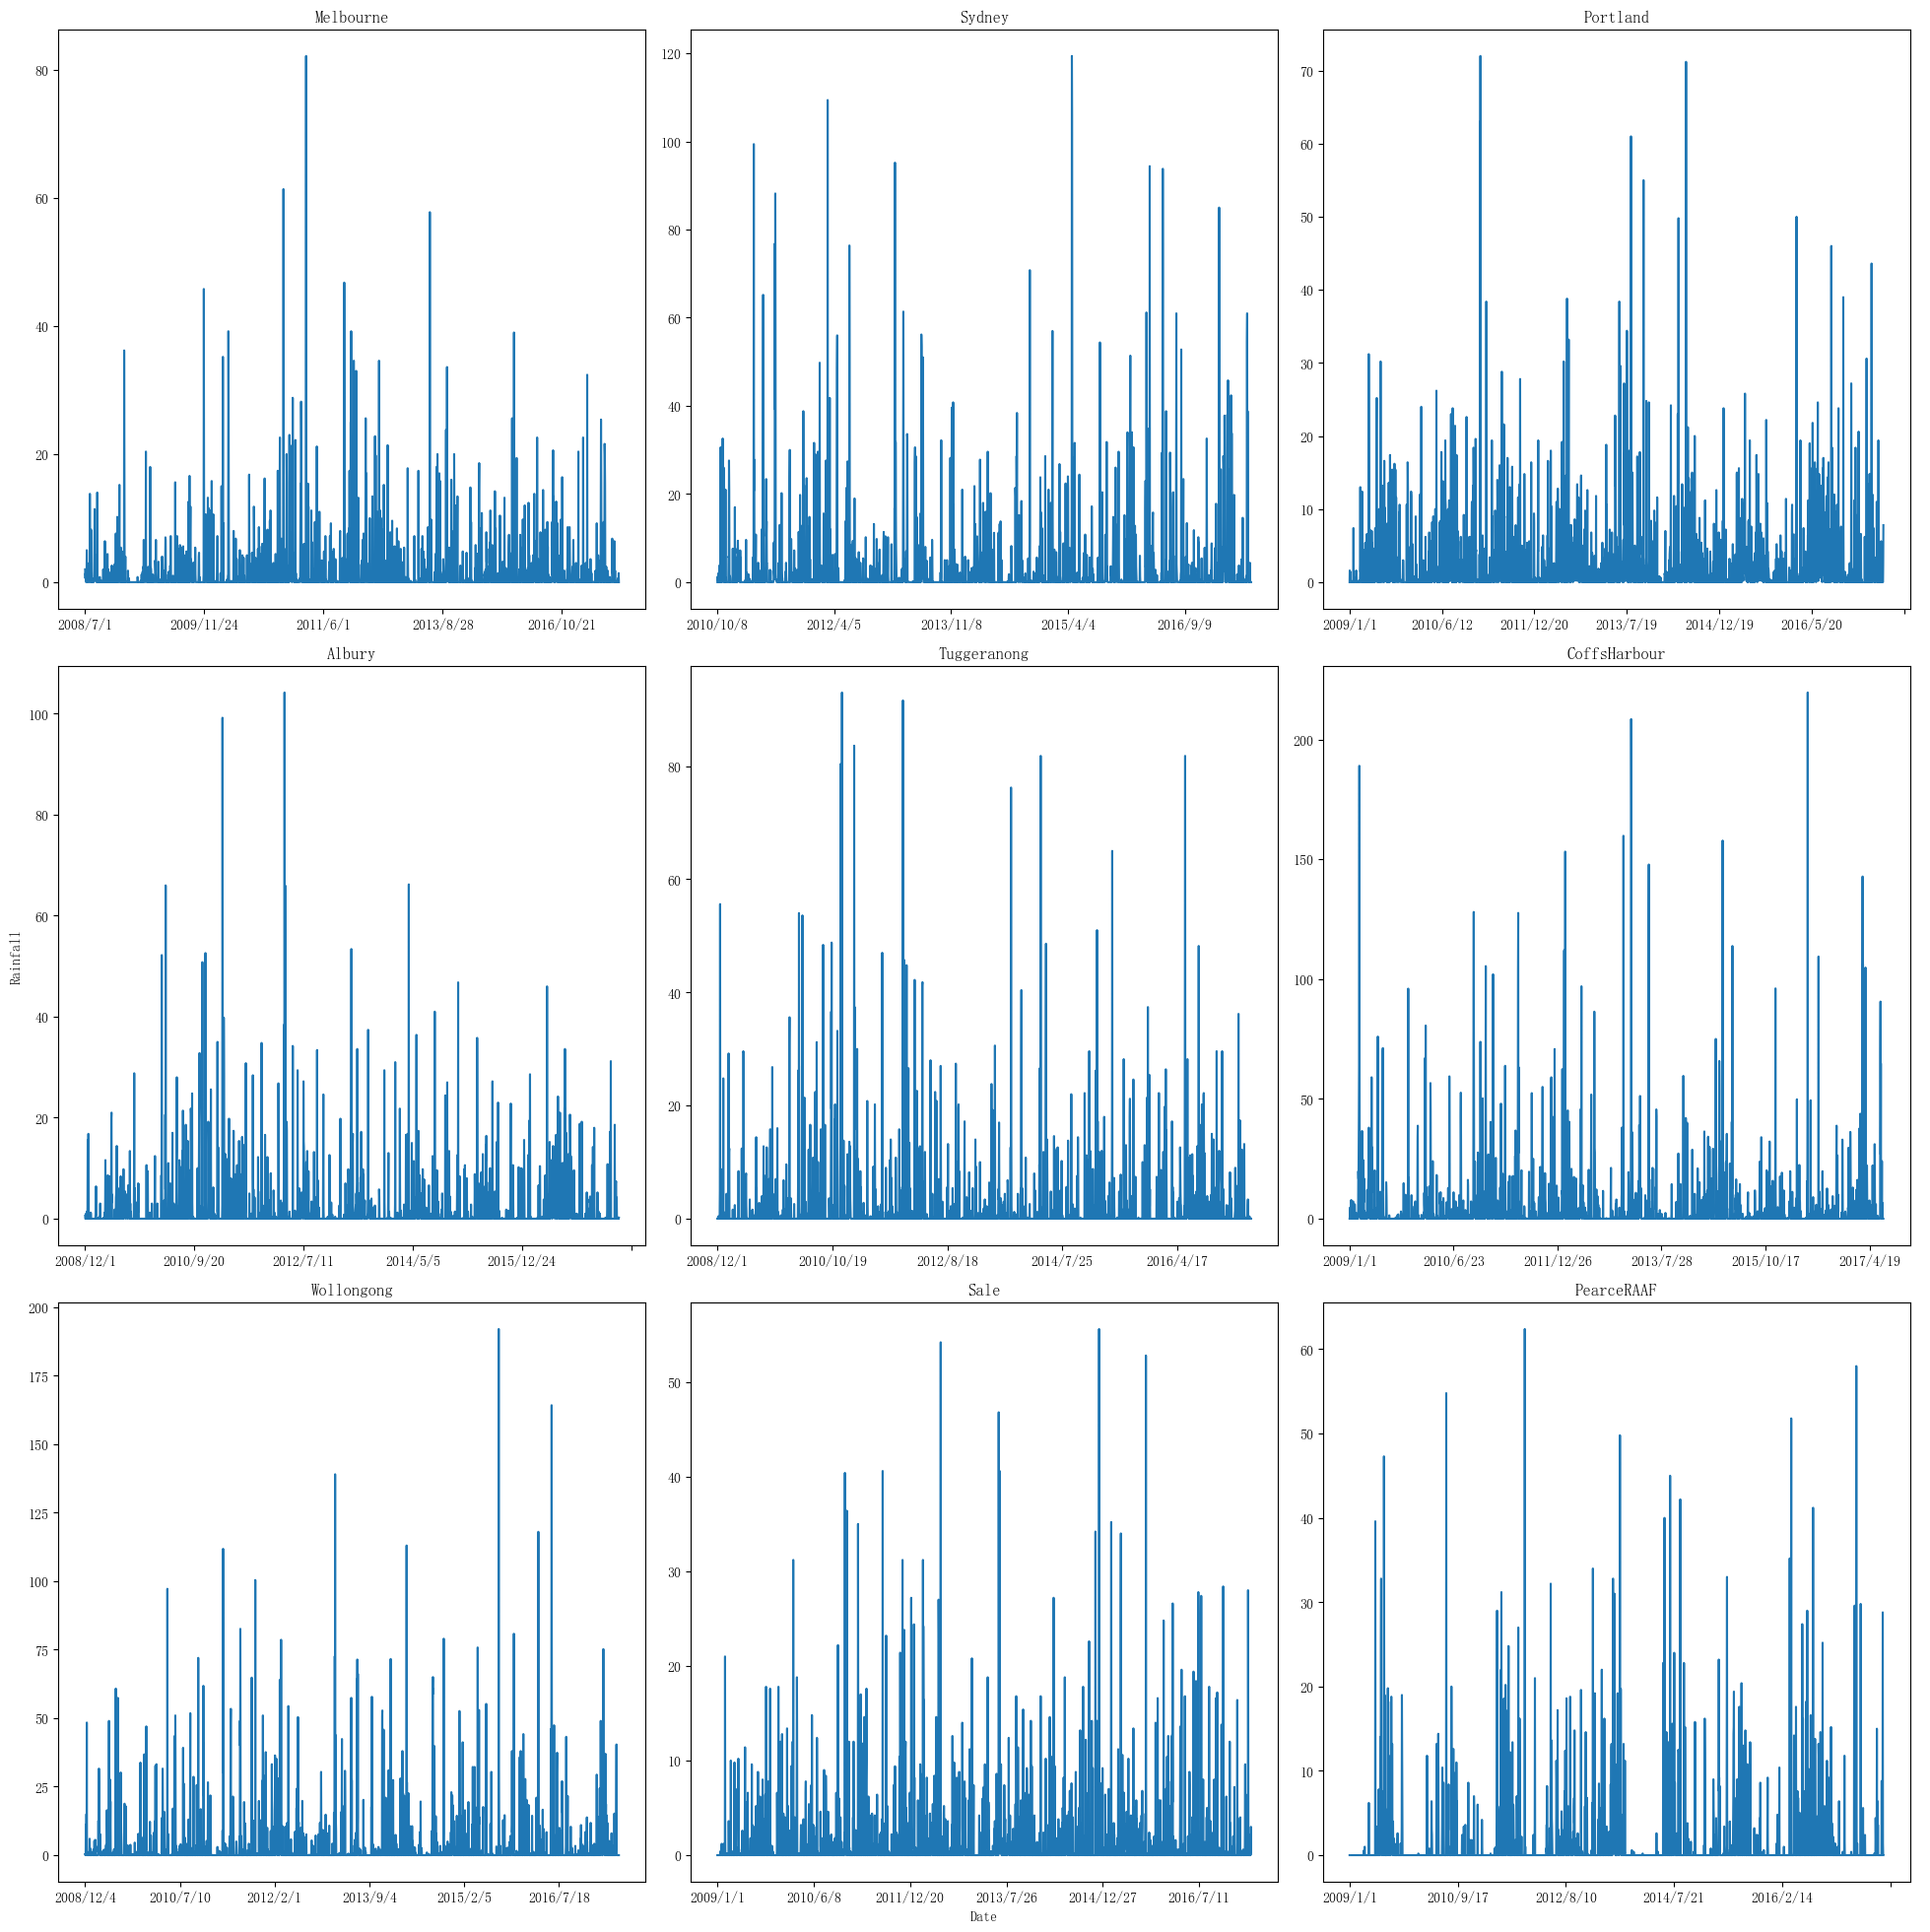

In [6]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20,20))

axes[0,0].plot(df_new[df_new['Location'] == 'Melbourne'].set_index('Date')['Rainfall'])
axes[0,0].set_title('Melbourne')
axes[0,0].xaxis.set_major_locator(ticker.MultipleLocator(base=500)) 

axes[0,1].plot(df_new[df_new['Location'] == 'Sydney'].set_index('Date')['Rainfall'])
axes[0,1].set_title('Sydney')
axes[0,1].xaxis.set_major_locator(ticker.MultipleLocator(base=500)) 

axes[0,2].plot(df_new[df_new['Location'] == 'Portland'].set_index('Date')['Rainfall'])
axes[0,2].set_title('Portland')
axes[0,2].xaxis.set_major_locator(ticker.MultipleLocator(base=500))

axes[1,0].plot(df_new[df_new['Location'] == 'Albury'].set_index('Date')['Rainfall'])
axes[1,0].set_title('Albury')
axes[1,0].xaxis.set_major_locator(ticker.MultipleLocator(base=500)) 

axes[1,1].plot(df_new[df_new['Location'] == 'Tuggeranong'].set_index('Date')['Rainfall'])
axes[1,1].set_title('Tuggeranong')
axes[1,1].xaxis.set_major_locator(ticker.MultipleLocator(base=500)) 

axes[1,2].plot(df_new[df_new['Location'] == 'CoffsHarbour'].set_index('Date')['Rainfall'])
axes[1,2].set_title('CoffsHarbour')
axes[1,2].xaxis.set_major_locator(ticker.MultipleLocator(base=500)) 

axes[2,0].plot(df_new[df_new['Location'] == 'Wollongong'].set_index('Date')['Rainfall'])
axes[2,0].set_title('Wollongong')
axes[2,0].xaxis.set_major_locator(ticker.MultipleLocator(base=500)) 

axes[2,1].plot(df_new[df_new['Location'] == 'Sale'].set_index('Date')['Rainfall'])
axes[2,1].set_title('Sale')
axes[2,1].xaxis.set_major_locator(ticker.MultipleLocator(base=500)) 

axes[2,2].plot(df_new[df_new['Location'] == 'PearceRAAF'].set_index('Date')['Rainfall'])
axes[2,2].set_title('PearceRAAF')
axes[2,2].xaxis.set_major_locator(ticker.MultipleLocator(base=500)) 

# 设置共享的x轴和y轴标签
fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", top=False, bottom=False, left=False, right=False)

# 解决X轴密集问题
plt.xlabel("Date")
plt.ylabel("Rainfall")

# 调整子图之间的间距
plt.tight_layout()
plt.show()

从上述两张降水的图片可以看出：澳大利亚地区的降雨有很明显的旱季和雨季，这在大多数区域都是适用的；此外，不同地区降雨分化较为明显，Coffsharbor、Portland等地降水量较大，而Sale、PearceRAAF等地降水量较少，甚至有些地区几乎不降水。

因此，在预测第二天是否下雨的模型中，我们得出两点建议：
- 一、地区性。我们将地区的地理位置因素纳入考虑，可以作为一个判断的特征。如果该地区在历史上降水量较小，那么在预测第二天下雨的概率也就更小。
- 二、季节性。我们发现降雨天气具有明显的季节性，如果前一天在下雨，后一天下雨的概率也会大一点。因此，在模型中应该有季节判断的考量

<strong> 温度情况和变化趋势 </strong>

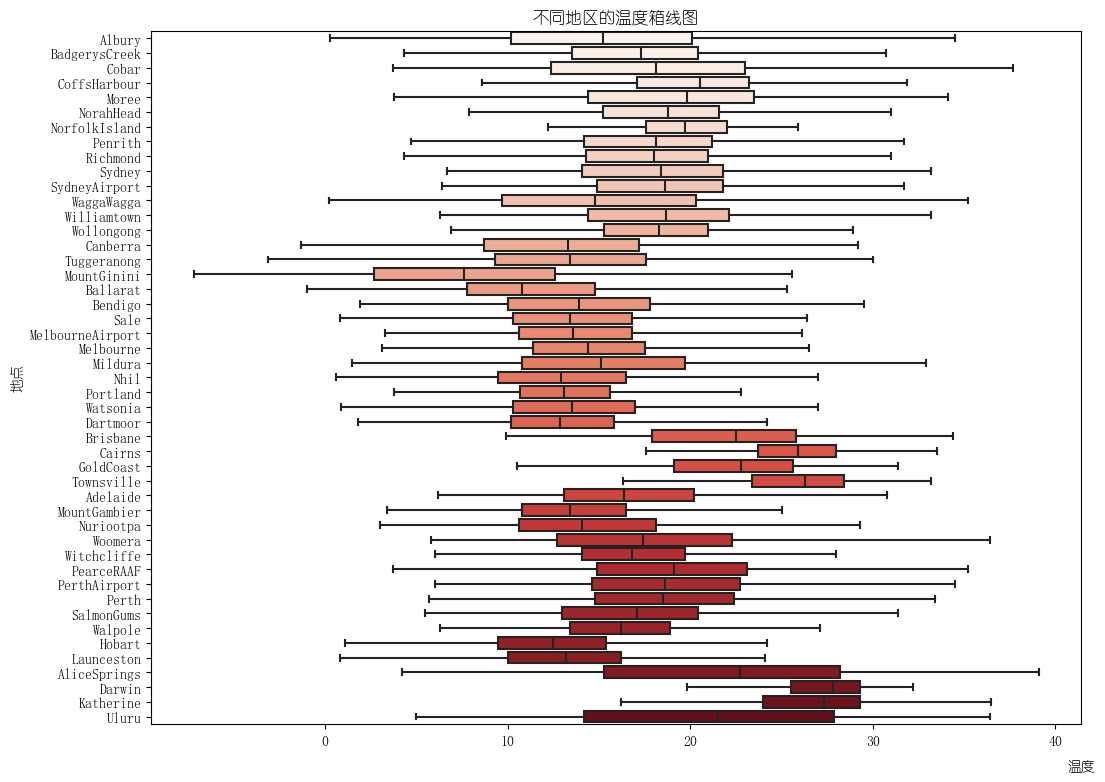

In [7]:
# 绘制不同地区温度的箱线图
matplotlib.rc("font",family='YouYuan')

fig, ax = plt.subplots(figsize=(12, 9))
fig = sns.boxplot(x="Temp9am", y="Location", data=df_new, showfliers=False, palette="Reds")
ax.set(xlabel="温度", ylabel="地点", title="不同地区的温度箱线图")
ax.xaxis.set_label_coords(1, -0.05)
plt.show()

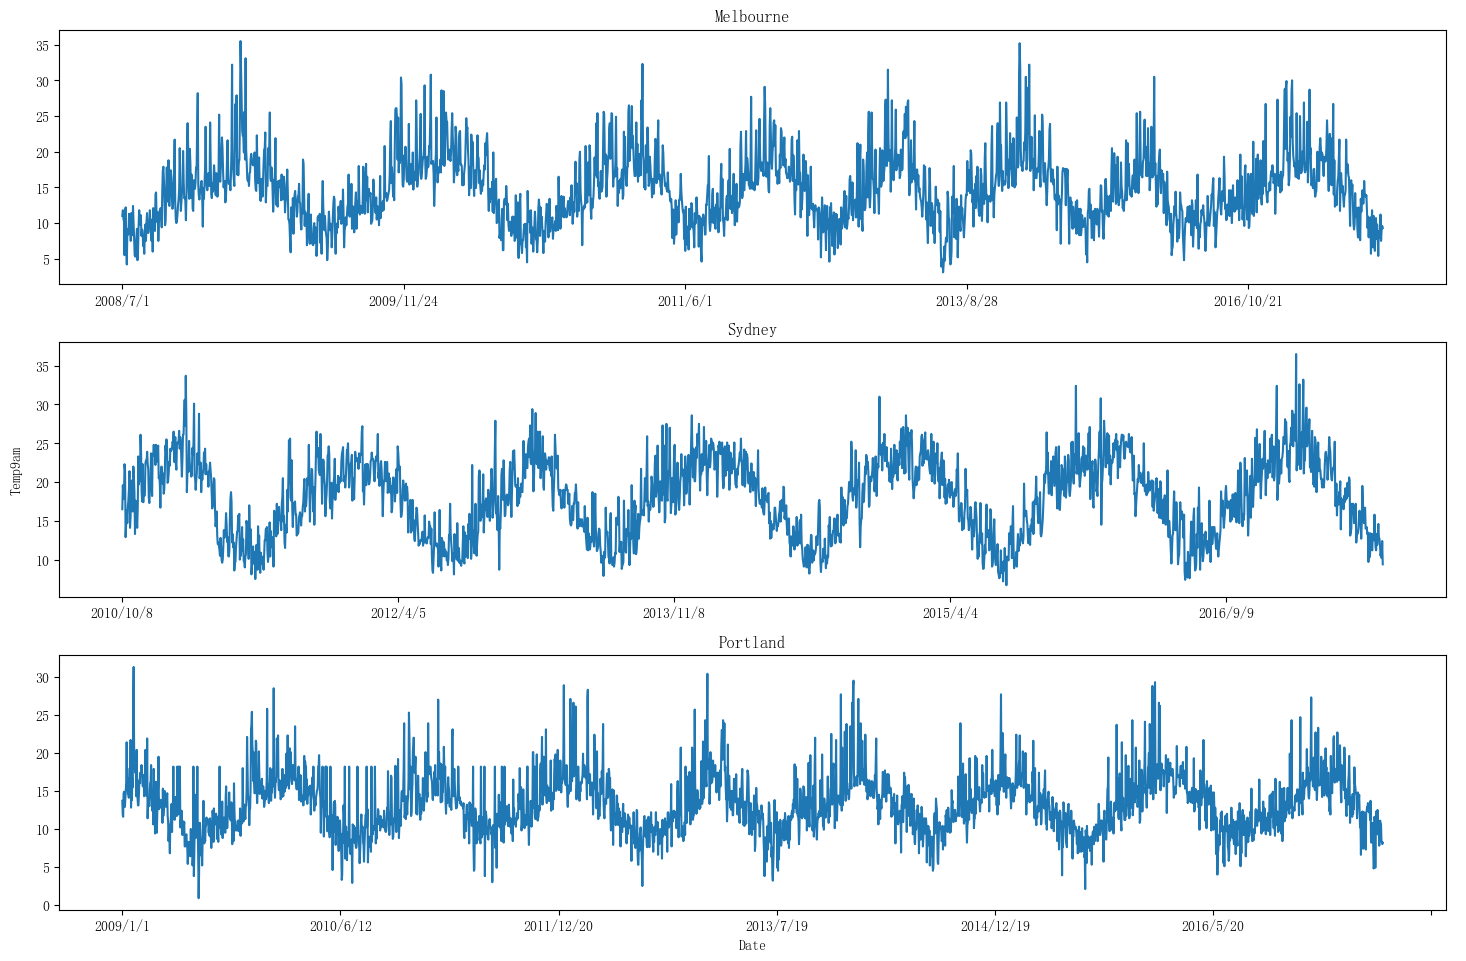

In [8]:
fig, axes = plt.subplots(nrows=3, figsize=(15,10))

axes[0].plot(df_new[df_new['Location'] == 'Melbourne'].set_index('Date')['Temp9am'])
axes[0].set_title('Melbourne')
axes[0].xaxis.set_major_locator(ticker.MultipleLocator(base=500)) 

axes[1].plot(df_new[df_new['Location'] == 'Sydney'].set_index('Date')['Temp9am'])
axes[1].set_title('Sydney')
axes[1].xaxis.set_major_locator(ticker.MultipleLocator(base=500)) 

axes[2].plot(df_new[df_new['Location'] == 'Portland'].set_index('Date')['Temp9am'])
axes[2].set_title('Portland')
axes[2].xaxis.set_major_locator(ticker.MultipleLocator(base=500)) 

# 设置共享的x轴和y轴标签
fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", top=False, bottom=False, left=False, right=False)

plt.xlabel("Date")
plt.ylabel("Temp9am")

# 调整子图之间的间距
plt.tight_layout()
plt.show()

分析各地区温度的逐年变化和统计数据中，我们发现各地温度的变化较为明显，在每年的波动中都有一个季节性的规律。另外，各地区温度的情况大概分化出两种类型：一、平均温度较高且温度跨度较小，如Cairns、Townsville等地区，这些地区可能处于靠近热带的位置，温度持续较高；二、平均温度较低且温度跨度较大，如AliceSprings、Uluru，这些地区更处于季风气候带或者海洋气候带，全年气温跨度较大。

<strong> 风向占比 </strong>

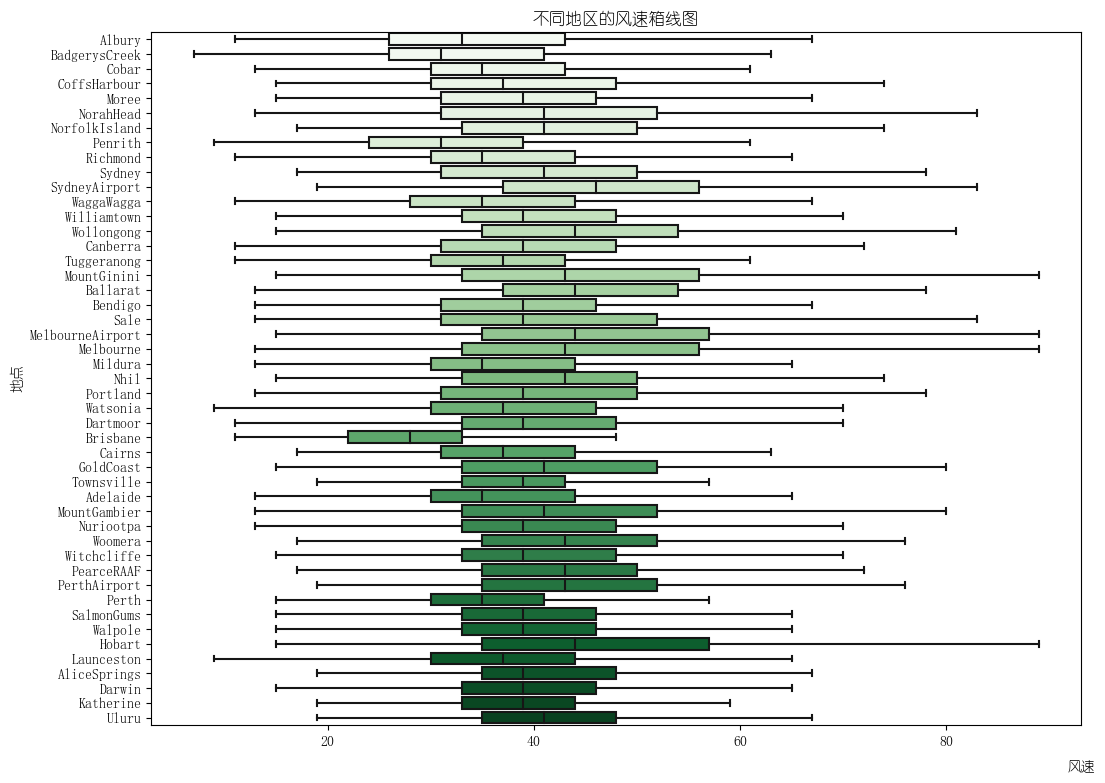

In [9]:
# 绘制不同地区风速的箱线图
matplotlib.rc("font",family='YouYuan')

fig, ax = plt.subplots(figsize=(12, 9))
fig = sns.boxplot(x="WindGustSpeed", y="Location", data=df_new, showfliers=False, palette="Greens")
ax.set(xlabel="风速", ylabel="地点", title="不同地区的风速箱线图")
ax.xaxis.set_label_coords(1, -0.05)
plt.show()

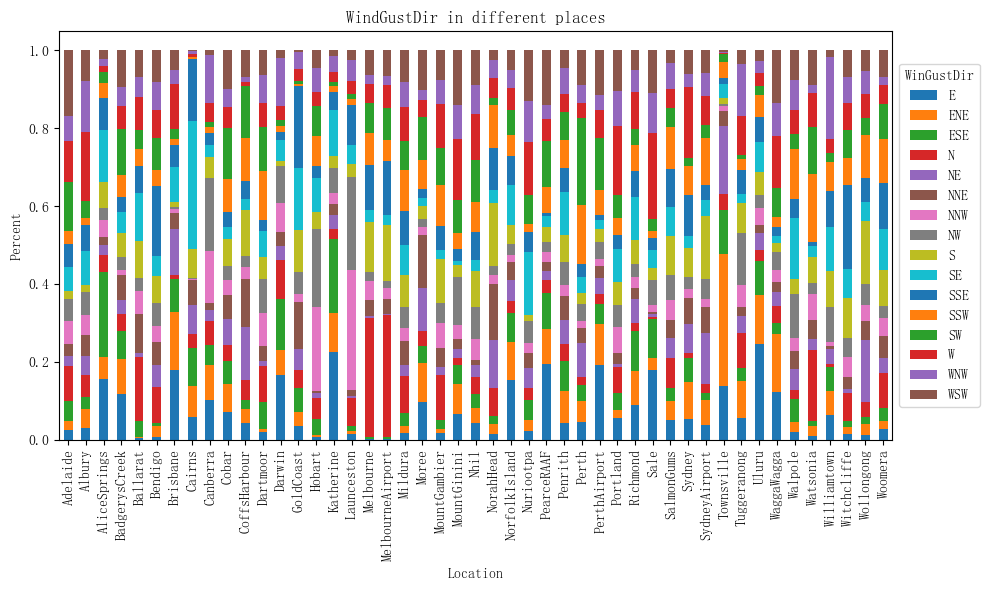

In [10]:
# 根据地点和风向进行分组并计算占比
grouped = df_new.groupby(['Location', 'WindGustDir']).size().unstack()
grouped = grouped.apply(lambda x: x / x.sum(), axis=1)  # 计算占比

# 绘制堆叠条形图
ax = grouped.plot(kind='bar', stacked=True, figsize=(10, 6))

# 设置图形参数
ax.set_xlabel('Location')
ax.set_ylabel('Percent')
ax.set_title('WindGustDir in different places')

# 添加图例
ax.legend(title='WinGustDir', loc='center left', bbox_to_anchor=(1, 0.5))

# 显示图形
plt.tight_layout()

通过风速风向的分析，我们发现不同地区的风速风向差异也较大。比如Mellbourne北风占比很高，且风速变化范较大；而Perth风向变化较大，平均风速较小，导致每个风向的影响范围较小

# 相关性分析

为了进一步探讨各个天气特征之间的联系以及它们和明天是否下雨的直观联系，我们在这里采用热力图相关性和时序相关性分析。

<strong>热力图相关性</strong>

In [11]:
# 定义风向编码字典
wind_direction_encoding = {
    'N': 0,
    'NNE': 1,
    'NE': 2,
    'ENE': 3,
    'E': 4,
    'ESE': 5,
    'SE': 6,
    'SSE': 7,
    'S': 8,
    'SSW': 9,
    'SW': 10,
    'WSW': 11,
    'W': 12,
    'WNW': 13,
    'NW': 14,
    'NNW': 15
}

# 使用map函数进行编码
df_new['WindGustDir_encoded'] = df_new['WindGustDir'].map(wind_direction_encoding)
df_new['WindDir9am_encoded'] = df_new['WindDir9am'].map(wind_direction_encoding)
df_new['WindDir3pm_encoded'] = df_new['WindDir3pm'].map(wind_direction_encoding)

In [12]:
df_mathvalue = df_new.iloc[:,[2,3,4,6]+list(range(9,22))]

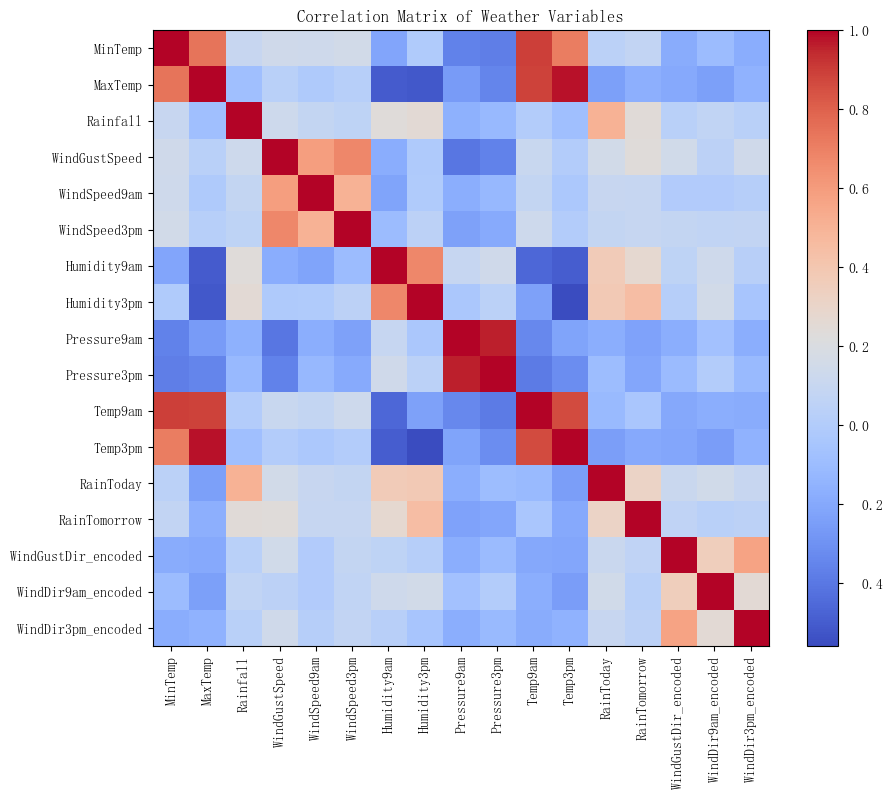

In [13]:
# 计算相关性矩阵
correlation_matrix = df_mathvalue.corr()

# 绘制相关性矩阵图表
plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(df_mathvalue.columns)), df_mathvalue.columns, rotation=90)
plt.yticks(range(len(df_mathvalue.columns)), df_mathvalue.columns)
plt.title('Correlation Matrix of Weather Variables')
plt.show()

从热力图的相关性分析可以直观看出两点：
1. 同一类型的天气属性，比如当天上下午的气温、气压、湿度、风速，以及平均风速和风向，平均降雨量和明天是否下雨，有着明显的相关性。这一点也是直观上可以理解的。
2. 和明天是否下雨比较相关的变量有：当天下午的湿度、当天的气压、当天最高温度以及当天是否下雨等。

<strong> 时序相关性 </strong>

问题提出：从热力图简单观察来看，明天是否下雨和当天的湿度、气压、最高温度、当天是否下雨等有较为明显的关系。现在从中挑选湿度、气压这两个因素作为代表，并考察他们是否和第二天是否下雨存在明显的时序相关性

In [14]:
# 定义时序相关性的函数
def timecorr(x,y,df,date):
    corr = [0]*10
    for i in range(10, len(df[y])):
        corri = df.iloc[i-10:i][x].corr(df.iloc[i-10:i][y])
        corr.append(corri)
    return pd.concat([df[date],pd.DataFrame(corr)],axis=1).set_index(date)

In [15]:
df1 = df_new.groupby('Date')[['Humidity9am','Humidity3pm','Pressure9am','Pressure3pm','RainTomorrow']].mean().reset_index()

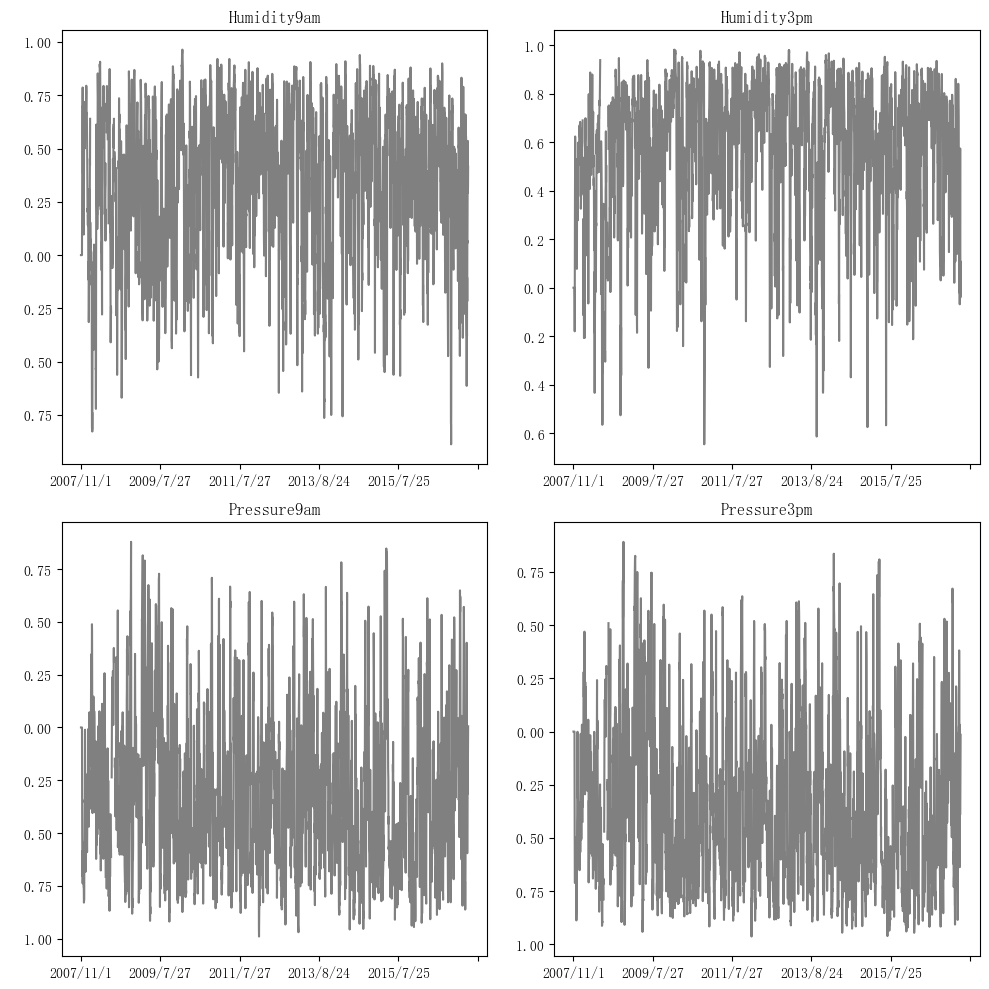

In [22]:
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(10,10))
ax[0,0].plot(timecorr('Humidity9am','RainTomorrow',df1,'Date')[0],color='gray')
ax[0,0].set_title('Humidity9am')
ax[0,0].xaxis.set_major_locator(ticker.MultipleLocator(base=700)) 


ax[0,1].plot(timecorr('Humidity3pm','RainTomorrow',df1,'Date')[0],color='gray')
ax[0,1].set_title('Humidity3pm')
ax[0,1].xaxis.set_major_locator(ticker.MultipleLocator(base=700)) 

ax[1,0].plot(timecorr('Pressure9am','RainTomorrow',df1,'Date')[0],color='gray')
ax[1,0].set_title('Pressure9am')
ax[1,0].xaxis.set_major_locator(ticker.MultipleLocator(base=700)) 

ax[1,1].plot(timecorr('Pressure3pm','RainTomorrow',df1,'Date')[0],color='gray')
ax[1,1].set_title('Pressure3pm')
ax[1,1].xaxis.set_major_locator(ticker.MultipleLocator(base=700)) 

# 调整子图之间的间距
plt.tight_layout()
plt.show()

以上四张图显示了各个因素和明天是否下雨的时间序列相关性。可以看出湿度所在的区间主要集中在0.5-0.75的范围内，在长时间保持了对于明天是否下雨的良好预测性。而气压的预测性较差，平均来看相关性在正负范围都有分布

# 天气状况聚类分析

为了进一步分析天气状况和地区之间的联系，我们将地区按照天气属性聚类，并考察每一类的性质

In [23]:
df_location = pd.concat([df_mathvalue, df_new['Location']], axis=1)
df_location_ave = df_location.groupby('Location').mean().reset_index()

<strong> 降维处理:</strong> 因为特征数过多，先用TSNE和PCA方法对特征进行降维处理

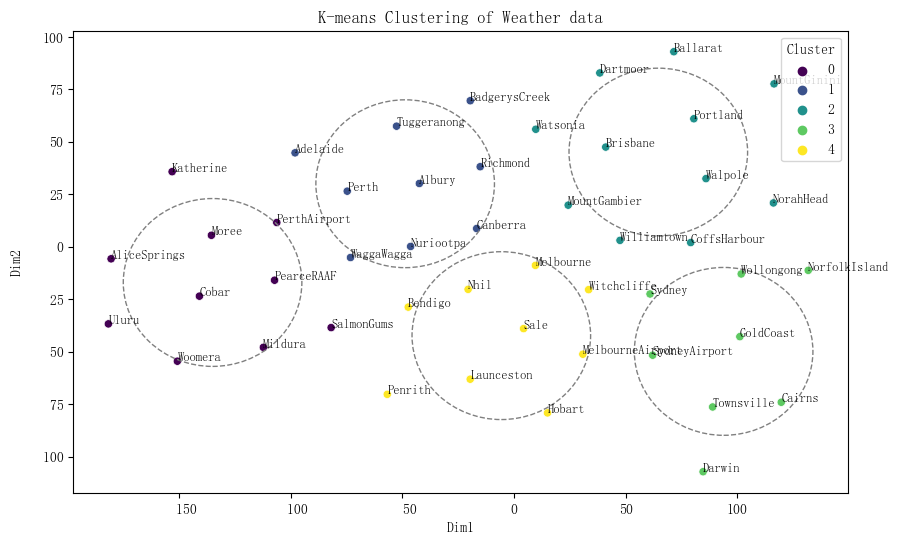

In [25]:
# 降维处理
tsne = TSNE(n_components=2, random_state=42)
data_tsne = tsne.fit_transform(df_location_ave.drop('Location',axis=1))

df_tsne = pd.DataFrame(data_tsne, columns=['Dimension 1', 'Dimension 2'])
df_location_tsne = pd.concat([df_location_ave['Location'],df_tsne],axis=1)

kmeans = KMeans(n_clusters=5)
kmeans.fit(df_location_tsne.drop('Location',axis=1))

# 将分类标签添加至新的df
df_location_tsne['Cluster'] = kmeans.labels_

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Dimension 1', y='Dimension 2', hue='Cluster', data=df_location_tsne, palette='viridis')
plt.xlabel('Dim1')
plt.ylabel('Dim2')
plt.title('K-means Clustering of Weather data')

# 画出虚线圈范围
centers = kmeans.cluster_centers_
for i in range(len(centers)):
    circle = Circle((centers[i, 0], centers[i, 1]), radius=40, linestyle='dashed', edgecolor='grey', facecolor='none')
    plt.gca().add_patch(circle)

font_props = {'fontsize': 9, 'fontweight': 'bold', 'color': 'black'}
for i in range(len(df_location_tsne['Cluster'])):
    plt.text(df_location_tsne['Dimension 1'][i], df_location_tsne['Dimension 2'][i], df_location_tsne['Location'][i], fontdict=font_props)

plt.show()

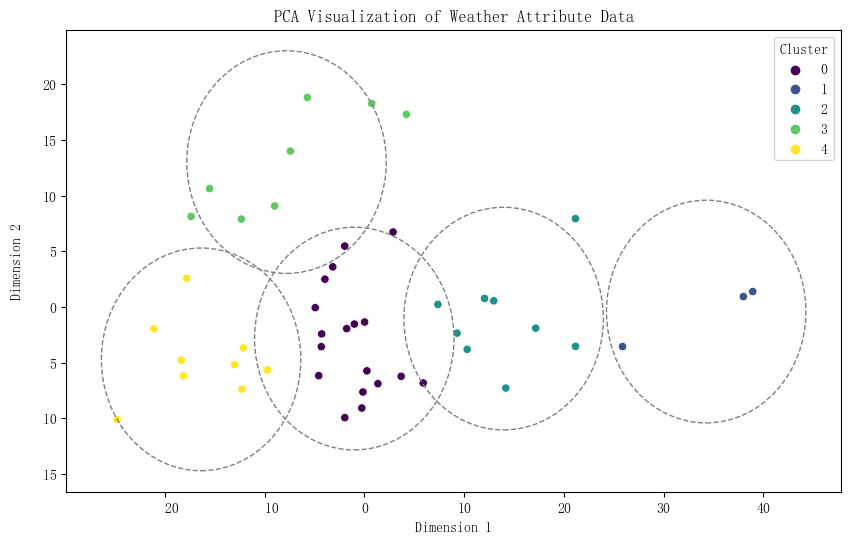

In [26]:
# PCA降维分析
pca = PCA(n_components=2, random_state=42)
data_pca = pca.fit_transform(df_location_ave.drop('Location',axis=1))

df_pca = pd.DataFrame(data_pca, columns=['Dimension 1', 'Dimension 2'])

kmeans = KMeans(n_clusters=5)
kmeans.fit(df_pca)

df_pca['Cluster'] = kmeans.labels_

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Dimension 1', y='Dimension 2', hue='Cluster', data=df_pca, palette='viridis')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('PCA Visualization of Weather Attribute Data')

centers = kmeans.cluster_centers_
for i in range(len(centers)):
    circle = Circle((centers[i, 0], centers[i, 1]), radius=10, linestyle='dashed', edgecolor='grey', facecolor='none')
    plt.gca().add_patch(circle)

plt.show()

从图中可以看出，TSNE降维后聚类效果较好，因此在后续分析中采用TSNE降维后聚类的类别

<strong>考察不同类别地点性质</strong>

In [27]:
# 创建一个地名和种类的字典映射关系
mapping = dict(zip(df_location_tsne['Location'], df_location_tsne['Cluster']))
# 在 df_location 中添加种类一列
df_location['Cluster'] = df_location['Location'].map(mapping)

Text(0.5, 1.0, 'distribution of Rainfall')

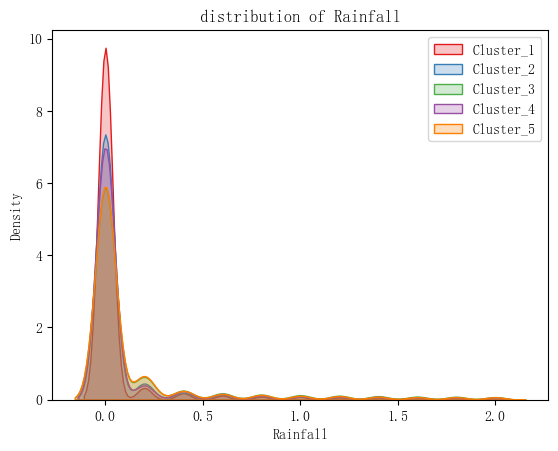

In [28]:
df_location_rain = df_location.copy()
df_location_rain.loc[df_location_rain['Rainfall'] > 2, 'Rainfall'] = 0
c1, c2, c3, c4, c5 = sns.color_palette('Set1', 5)
sns.kdeplot(df_location_rain[df_location_rain['Cluster'] == 0].Rainfall, shade = True, color=c1, label = 'Cluster_1')
sns.kdeplot(df_location_rain[df_location_rain['Cluster'] == 1].Rainfall, shade = True, color=c2, label = 'Cluster_2')
sns.kdeplot(df_location_rain[df_location_rain['Cluster'] == 2].Rainfall, shade = True, color=c3, label = 'Cluster_3')
sns.kdeplot(df_location_rain[df_location_rain['Cluster'] == 3].Rainfall, shade = True, color=c4, label = 'Cluster_4')
sns.kdeplot(df_location_rain[df_location_rain['Cluster'] == 4].Rainfall, shade = True, color=c5, label = 'Cluster_5')
plt.legend()
plt.title('distribution of Rainfall')

从降雨量的累积分布图可以看出，这五种地区的降雨量分布并没有很大不同，这可能和澳大利亚地区将与的整体情况有关。但第三类地区的峰值较为突出，是因为这些地区有较为明显的雨季，且这段时间降水概率较高，比如Albury。

Text(0.5, 1.0, 'distribution of MaxTemp')

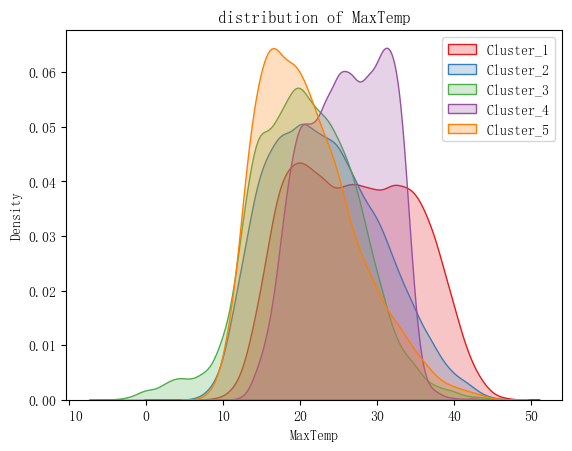

In [30]:
c1, c2, c3, c4, c5 = sns.color_palette('Set1', 5)
sns.kdeplot(df_location[df_location['Cluster'] == 0].MaxTemp, shade = True, color=c1, label = 'Cluster_1')
sns.kdeplot(df_location[df_location['Cluster'] == 1].MaxTemp, shade = True, color=c2, label = 'Cluster_2')
sns.kdeplot(df_location[df_location['Cluster'] == 2].MaxTemp, shade = True, color=c3, label = 'Cluster_3')
sns.kdeplot(df_location[df_location['Cluster'] == 3].MaxTemp, shade = True, color=c4, label = 'Cluster_4')
sns.kdeplot(df_location[df_location['Cluster'] == 4].MaxTemp, shade = True, color=c5, label = 'Cluster_5')
plt.legend()
plt.title('distribution of MaxTemp')

Text(0.5, 1.0, 'distribution of MinTemp')

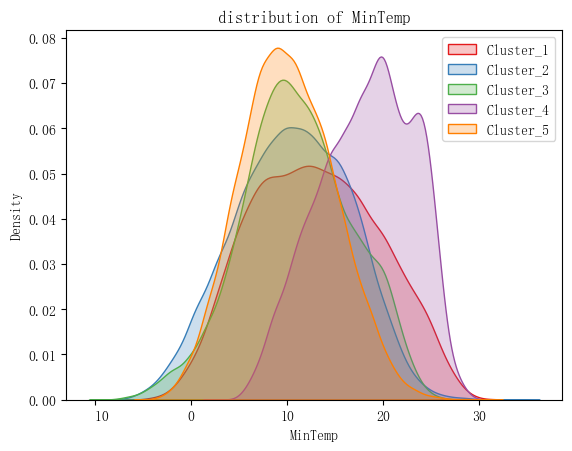

In [31]:
c1, c2, c3, c4, c5 = sns.color_palette('Set1', 5)
sns.kdeplot(df_location[df_location['Cluster'] == 0].MinTemp, shade = True, color=c1, label = 'Cluster_1')
sns.kdeplot(df_location[df_location['Cluster'] == 1].MinTemp, shade = True, color=c2, label = 'Cluster_2')
sns.kdeplot(df_location[df_location['Cluster'] == 2].MinTemp, shade = True, color=c3, label = 'Cluster_3')
sns.kdeplot(df_location[df_location['Cluster'] == 3].MinTemp, shade = True, color=c4, label = 'Cluster_4')
sns.kdeplot(df_location[df_location['Cluster'] == 4].MinTemp, shade = True, color=c5, label = 'Cluster_5')
plt.legend()
plt.title('distribution of MinTemp')

从两张温度的累积分布图可以看出，所有地区的最高温度和最低温度分布相适应。有两类地区的气温差异较大:第五类和第四类。第四类地区平均温度较低，为沿海和内陆交杂，天气变化不定所以总体跨度较大。比如Melbourne,Sale等。第五类温度平均较高，且多为靠海气候所以变化不大。比如Townsville,Sydney。

In [32]:
df_location

MinTemp  MaxTemp  Rainfall  WindGustSpeed  WindSpeed9am  WindSpeed3pm  \
0          13.4     22.9       0.6           44.0          20.0          24.0   
1           7.4     25.1       0.0           44.0           4.0          22.0   
2          12.9     25.7       0.0           46.0          19.0          26.0   
3           9.2     28.0       0.0           24.0          11.0           9.0   
4          17.5     32.3       1.0           41.0           7.0          20.0   
...         ...      ...       ...            ...           ...           ...   
145454      3.5     21.8       0.0           31.0          15.0          13.0   
145455      2.8     23.4       0.0           31.0          13.0          11.0   
145456      3.6     25.3       0.0           22.0          13.0           9.0   
145457      5.4     26.9       0.0           37.0           9.0           9.0   
145458      7.8     27.0       0.0           28.0          13.0           7.0   

        Humidity9am  Humidity3pm  Pressure9am  Pressure3pm  Temp9am  Temp3pm  \
0              71.0         22.0       1007.7       1007.1     16.9     21.8   
1              44.0         25.0       1010.6       1007.8     17.2     24.3   
2              38.0         30.0       1007.6       1008.7     21.0     23.2   
3              45.0         16.0       1017.6       1012.8     18.1     26.5   
4              82.0         33.0       1010.8       1006.0     17.8     29.7   
...             ...          ...          ...          ...      ...      ...   
145454         59.0         27.0       1024.7       1021.2      9.4     20.9   
145455         51.0         24.0       1024.6       1020.3     10.1     22.4   
145456         56.0         21.0       1023.5       1019.1     10.9     24.5   
145457         53.0         24.0       1021.0       1016.8     12.5     26.1   
145458         51.0         24.0       1019.4       1016.5     15.1     26.0   

        RainToday  RainTomorrow  WindGustDir_encoded  WindDir9am_encoded  \
0             0.0           0.0                   12                  12   
1             0.0           0.0                   13                  15   
2             0.0           0.0                   11                  12   
3             0.0           0.0                    2                   6   
4             0.0           0.0                   12                   3   
...           ...           ...                  ...                 ...   
145454        0.0           0.0                    4                   5   
145455        0.0           0.0                    4                   6   
145456        0.0           0.0                   15                   6   
145457        0.0           0.0                    0                   6   
145458        0.0           0.0                    6                   7   

        WindDir3pm_encoded Location  Cluster  
0                       13   Albury        1  
1                       11   Albury        1  
2                       11   Albury        1  
3                        4   Albury        1  
4                       14   Albury        1  
...                    ...      ...      ...  
145454                   4    Uluru        0  
145455                   3    Uluru        0  
145456                   0    Uluru        0  
145457                  13    Uluru        0  
145458                   0    Uluru        0  

[123710 rows x 19 columns]

<strong>提琴图绘制：</strong>为了进一步分析各个地区的每个天气属性的分布情况，我们绘制提琴图如下：

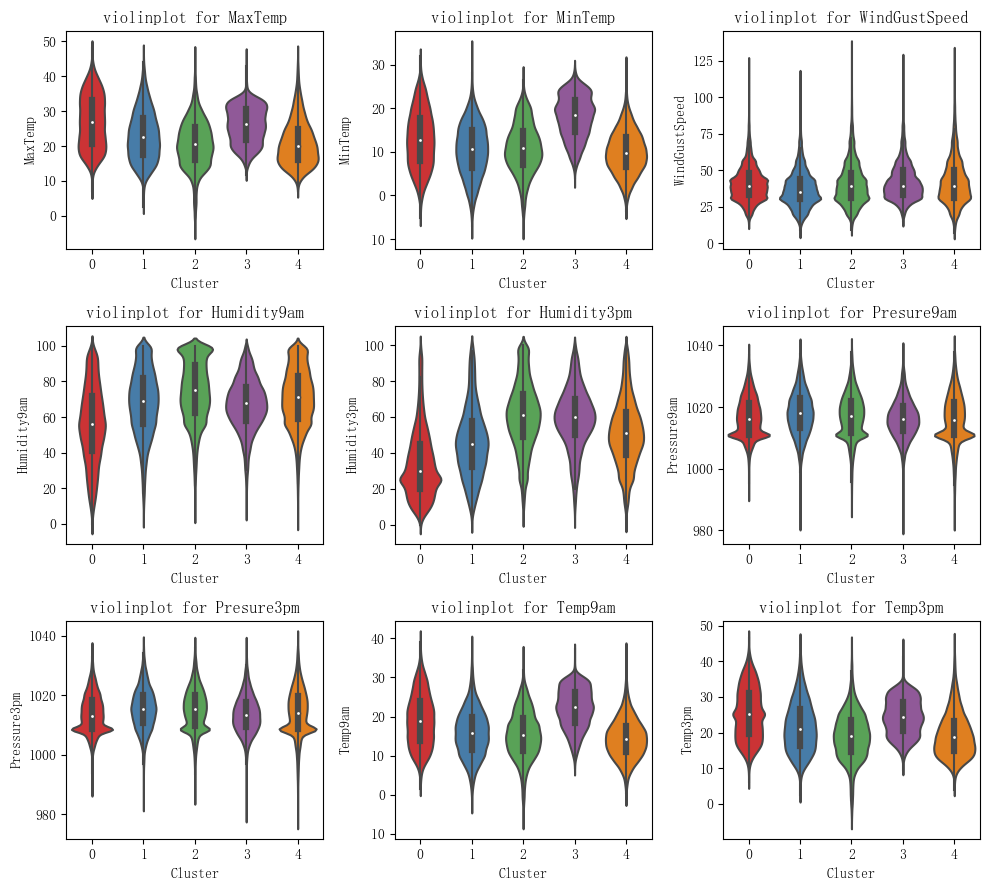

In [33]:
fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(10, 9))
sns.violinplot(x = "Cluster", y = "MaxTemp", data=df_location,palette=[c1,c2,c3,c4,c5], ax=axes[0,0])
axes[0,0].set_title('violinplot for MaxTemp')

sns.violinplot(x = "Cluster", y = "MinTemp", data=df_location,palette=[c1,c2,c3,c4,c5], ax=axes[0,1])
axes[0,1].set_title('violinplot for MinTemp')

sns.violinplot(x = "Cluster", y = "WindGustSpeed", data=df_location,palette=[c1,c2,c3,c4,c5], ax=axes[0,2])
axes[0,2].set_title('violinplot for WindGustSpeed')

sns.violinplot(x = "Cluster", y = "Humidity9am", data=df_location,palette=[c1,c2,c3,c4,c5], ax=axes[1,0])
axes[1,0].set_title('violinplot for Humidity9am')

sns.violinplot(x = "Cluster", y = "Humidity3pm", data=df_location,palette=[c1,c2,c3,c4,c5], ax=axes[1,1])
axes[1,1].set_title('violinplot for Humidity3pm')

sns.violinplot(x = "Cluster", y = "Pressure9am", data=df_location,palette=[c1,c2,c3,c4,c5], ax=axes[1,2])
axes[1,2].set_title('violinplot for Presure9am')

sns.violinplot(x = "Cluster", y = "Pressure3pm", data=df_location,palette=[c1,c2,c3,c4,c5], ax=axes[2,0])
axes[2,0].set_title('violinplot for Presure3pm')

sns.violinplot(x = "Cluster", y = "Temp9am", data=df_location,palette=[c1,c2,c3,c4,c5], ax=axes[2,1])
axes[2,1].set_title('violinplot for Temp9am')

sns.violinplot(x = "Cluster", y = "Temp3pm", data=df_location,palette=[c1,c2,c3,c4,c5], ax=axes[2,2])
axes[2,2].set_title('violinplot for Temp3pm')


# 调整子图之间的间距
plt.tight_layout()
# 显示图形
plt.show()

---

# Part2 时间序列预测分析

In [98]:
# 数据读取
df_new["Date"] = df_new["Date"].astype("datetime64")
df_new.head()

Date Location  MinTemp  MaxTemp  Rainfall WindGustDir  WindGustSpeed  \
0 2008-12-01   Albury     13.4     22.9       0.6           W           44.0   
1 2008-12-02   Albury      7.4     25.1       0.0         WNW           44.0   
2 2008-12-03   Albury     12.9     25.7       0.0         WSW           46.0   
3 2008-12-04   Albury      9.2     28.0       0.0          NE           24.0   
4 2008-12-05   Albury     17.5     32.3       1.0           W           41.0   

  WindDir9am WindDir3pm  WindSpeed9am  ...  Pressure9am  Pressure3pm  Temp9am  \
0          W        WNW          20.0  ...       1007.7       1007.1     16.9   
1        NNW        WSW           4.0  ...       1010.6       1007.8     17.2   
2          W        WSW          19.0  ...       1007.6       1008.7     21.0   
3         SE          E          11.0  ...       1017.6       1012.8     18.1   
4        ENE         NW           7.0  ...       1010.8       1006.0     17.8   

   Temp3pm  RainToday  RainTomorrow  WindGustDir_encoded  WindDir9am_encoded  \
0     21.8        0.0           0.0                   12                  12   
1     24.3        0.0           0.0                   13                  15   
2     23.2        0.0           0.0                   11                  12   
3     26.5        0.0           0.0                    2                   6   
4     29.7        0.0           0.0                   12                   3   

   WindDir3pm_encoded  AvgTemp  
0                  13    18.15  
1                  11    16.25  
2                  11    19.30  
3                   4    18.60  
4                  14    24.90  

[5 rows x 23 columns]

# 温度时间序列分析: 总体概述

In [99]:
# 计算平均温度作为后续分析的主要统计量
df = df_new
df["AvgTemp"] = (df["MinTemp"]+df["MaxTemp"])/2
df_temp=df[["Date","Location","AvgTemp"]].set_index(["Date","Location"]).unstack().dropna()

In [100]:
df.groupby('Location')[["MinTemp","AvgTemp","MaxTemp"]].agg(["mean","median","std"]).round(1)

MinTemp             AvgTemp             MaxTemp            
                    mean median  std    mean median  std    mean median  std
Location                                                                    
Adelaide            12.9   12.4  4.9    18.0   17.2  5.6    23.1   21.9  7.0
Albury              10.4   10.0  5.8    16.9   16.8  6.5    23.4   23.1  7.9
AliceSprings        13.7   14.2  7.6    21.6   22.5  7.1    29.6   30.5  7.5
BadgerysCreek       11.5   11.7  5.5    17.8   17.7  5.2    24.1   23.3  6.0
Ballarat             7.5    7.0  4.7    12.9   12.1  5.5    18.3   17.0  7.2
Bendigo              9.0    8.7  5.5    15.5   15.0  6.2    22.0   21.3  7.6
Brisbane            16.4   16.8  4.6    21.4   21.8  4.0    26.5   26.7  3.9
Cairns              21.2   21.8  3.2    25.4   25.6  2.6    29.5   29.7  2.5
Canberra             7.2    7.3  6.0    14.1   14.0  6.0    21.0   20.7  6.9
Cobar               13.1   13.0  6.7    19.5   19.5  7.1    25.8   25.8  7.9
CoffsHarbour        14.5   15.3  5.1    19.3   19.7  4.1    24.0   24.2  3.8
Dartmoor             9.1    8.9  4.0    14.5   13.8  4.7    19.9   18.4  6.5
Darwin              23.2   23.9  3.0    27.9   28.3  2.1    32.5   32.8  1.7
GoldCoast           17.3   17.6  4.1    21.5   21.8  3.6    25.7   26.0  3.4
Hobart               9.1    9.0  3.9    13.5   13.2  4.1    17.9   17.3  5.0
Katherine           20.3   22.0  5.2    27.5   28.2  3.7    34.8   35.0  3.2
Launceston           8.5    8.7  4.7    14.0   13.9  4.5    19.4   19.2  5.0
Melbourne           11.8   11.5  4.2    16.4   15.8  4.8    21.0   19.7  6.1
MelbourneAirport    10.0    9.5  4.5    15.3   14.4  5.1    20.5   19.2  6.6
Mildura             10.9   10.2  6.0    17.9   17.2  6.5    25.0   24.2  7.7
Moree               12.9   13.6  6.8    20.0   20.4  6.5    27.1   27.4  6.9
MountGambier         8.9    8.6  4.0    14.4   13.7  4.6    19.9   18.6  6.4
MountGinini          3.7    3.2  5.3     7.7    7.6  6.0    11.8   11.7  7.1
Nhil                 9.1    8.5  5.1    15.9   15.1  5.9    22.6   21.4  7.7
NorahHead           15.3   15.5  4.1    18.9   19.1  4.0    22.6   22.4  4.3
NorfolkIsland       16.8   16.7  2.8    19.3   19.2  2.6    21.8   21.6  2.7
Nuriootpa            9.6    9.3  5.1    15.7   15.0  5.9    21.9   21.0  7.6
PearceRAAF          12.6   12.5  5.2    19.6   19.0  5.6    26.6   25.9  6.9
Penrith             13.1   13.6  5.3    19.1   19.2  5.3    25.1   24.4  6.2
Perth               13.1   13.2  5.0    19.1   18.6  5.2    25.2   24.1  6.1
PerthAirport        12.7   12.5  5.0    19.1   18.4  5.3    25.6   24.6  6.4
Portland             9.6    9.5  3.6    13.9   13.2  3.9    18.1   17.0  5.2
Richmond            12.4   13.0  5.7    18.7   18.7  5.3    24.9   24.4  6.1
Sale                 8.6    8.4  4.9    14.5   14.0  4.8    20.3   19.5  5.8
SalmonGums           9.4    9.3  5.4    16.9   16.6  5.4    24.4   23.7  6.8
Sydney              15.1   15.2  4.5    19.2   19.2  4.2    23.3   23.2  4.5
SydneyAirport       14.9   15.0  4.6    19.1   19.0  4.6    23.4   23.0  5.1
Townsville          20.6   21.6  4.4    25.0   25.7  3.4    29.4   29.7  2.8
Tuggeranong          8.0    8.2  6.0    14.5   14.4  6.0    21.1   20.7  6.9
Uluru               14.5   15.0  7.4    22.5   23.1  7.1    30.5   31.4  7.7
WaggaWagga           9.8    9.4  6.5    16.5   16.0  6.8    23.2   22.7  7.9
Walpole             12.1   12.1  3.2    16.4   16.2  3.5    20.7   20.2  4.6
Watsonia            10.2    9.9  4.5    15.6   14.9  5.1    21.0   19.8  6.8
Williamtown         12.9   13.0  5.2    18.6   18.5  4.8    24.3   23.9  5.4
Witchcliffe         11.1   11.2  3.8    16.6   16.2  3.9    22.0   21.1  5.2
Wollongong          14.9   14.9  3.8    18.2   18.2  3.7    21.5   21.3  4.0
Woomera             13.4   13.1  6.2    20.0   19.6  6.8    26.6   26.0  7.9

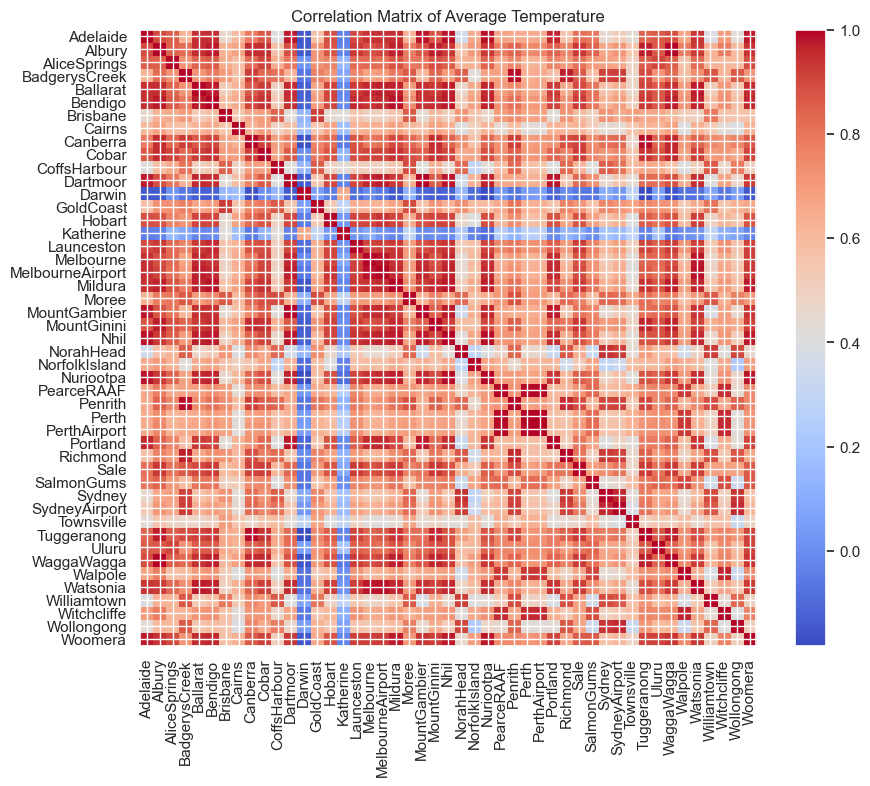

In [101]:
# 计算相关性矩阵
correlation_matrix = df_temp.corr()

# 绘制相关性矩阵图表
plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(df_temp.columns)), [col[1] for col in df_temp.columns.tolist()], rotation=90)
plt.yticks(range(len(df_temp.columns)), [col[1] for col in df_temp.columns.tolist()])
plt.title('Correlation Matrix of Average Temperature')
plt.show()

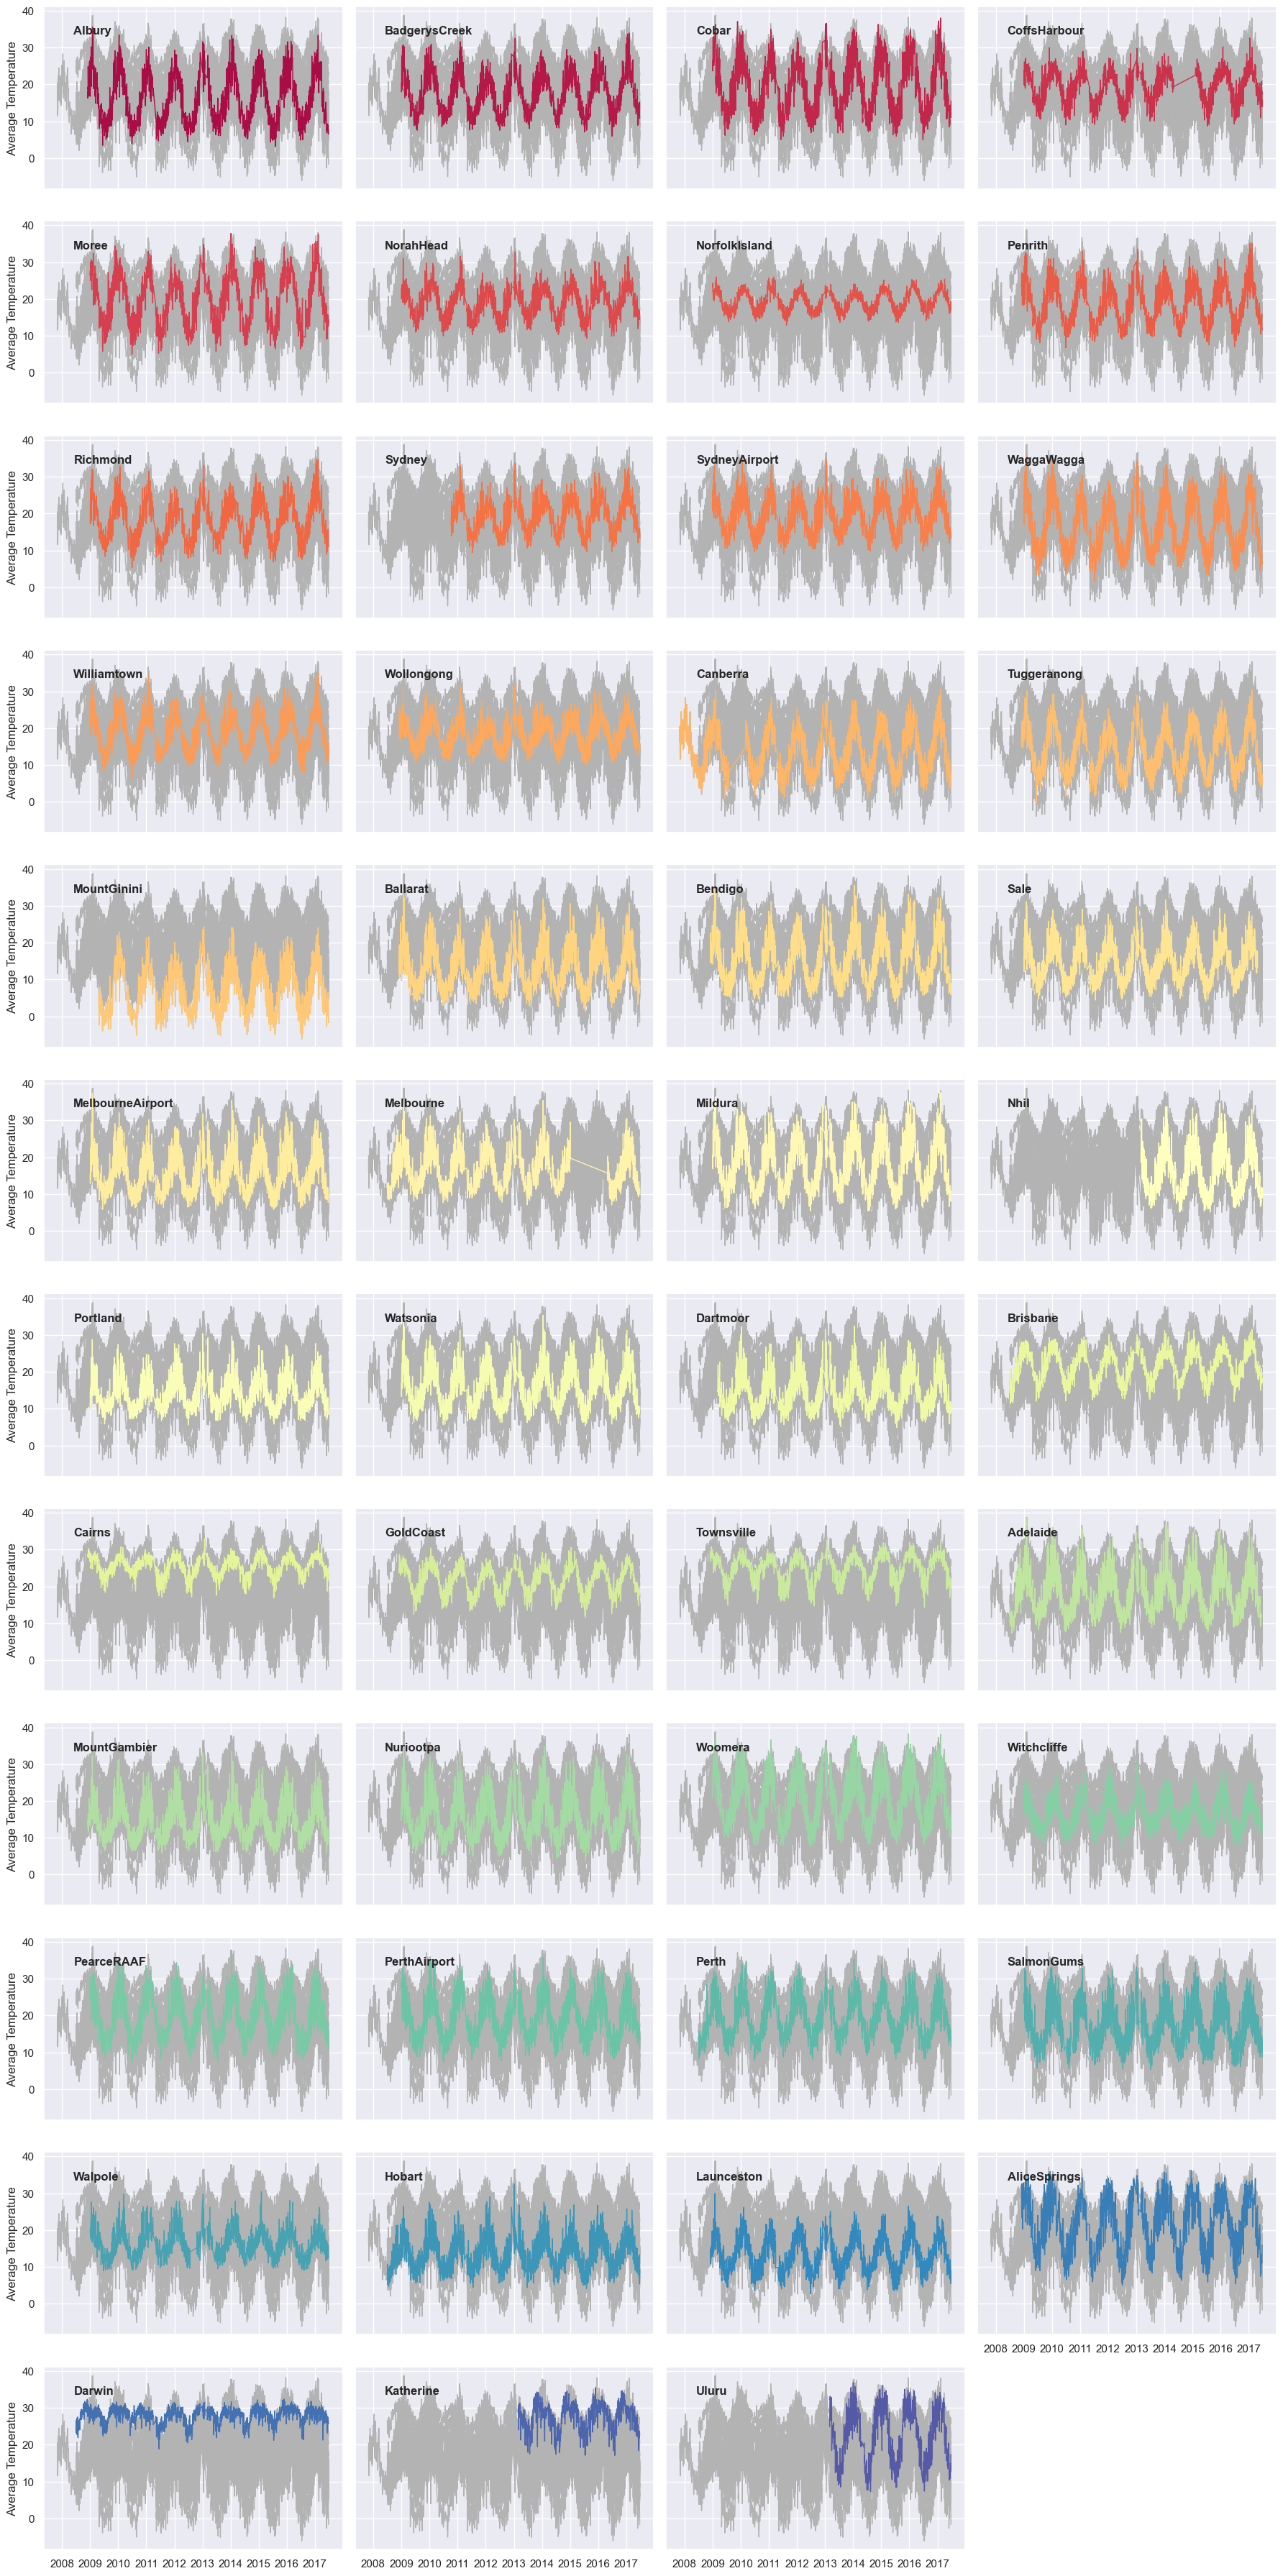

In [102]:
# 画出不同区域的气温走势图
g = sns.relplot(data = df, x = "Date", y = "AvgTemp",
                col = "Location", hue = "Location",
                kind = "line", palette = "Spectral",   
                linewidth = 1, zorder = 3,
                col_wrap = 4, height = 3, aspect = 1.5, legend = False
               )

for time, ax in g.axes_dict.items():
    ax.text(.1, .85, time,
            transform = ax.transAxes, fontweight="bold"
           )
    sns.lineplot(data = df, x = "Date", y = "AvgTemp", units="Location",
                 estimator = None, color= ".7", linewidth=1, ax=ax
                )

#ax.set_xticks('')
g.set_titles("")
g.set_axis_labels("", "Average Temperature")
g.tight_layout()

# 温度时间序列分析: 以Albury为例
在这一部分中，我们将对各个区域的温度进行建模，考虑到温度数据的强季节性，我们将对其构建时间序列模型

考虑到可供分析的地理位置数量较多，这里我们以Albury为例，并在其上建立了详细的模型。 我们选择Albury，因为它表现出较强的时间趋势，且数据相对完整，这可能对后续建模有所帮助。 请注意，我们将 2008年12月1日到2017年4月30日的数据作为训练数据，其余数据作为测试数据，以演示模型的效果。

In [44]:
# 提取Albury的数据并补充缺失的数据
idx = pd.DataFrame(index=pd.date_range(start="2008-12-1",end="2017-5-30"))
df_albury_temp = df.loc[df["Location"]=="Albury",["Date","MinTemp","MaxTemp","AvgTemp"]].copy().set_index("Date")
df_albury_temp = df_albury_temp.join(idx,how="outer").ffill()
df_albury_temp.index = df_albury_temp.index.to_pydatetime()

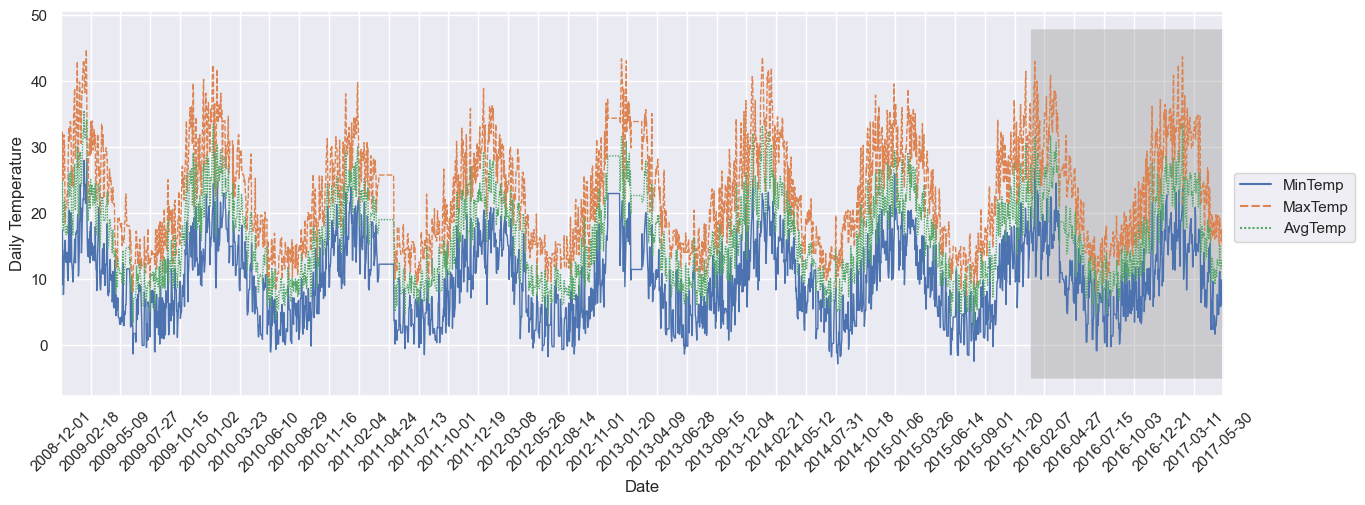

In [45]:
# 画出时间序列趋势图
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(15,5)})

ax = sns.lineplot(data=df_albury_temp[["MinTemp","MaxTemp","AvgTemp"]],legend="brief", lw=1)
ax.xaxis.set_major_locator(ticker.LinearLocator(40))

plt.fill_between(df_albury_temp.index,-5,48, where = df_albury_temp.index>pd.to_datetime("2015/12/30"),alpha=0.3,facecolor='gray')
plt.legend(bbox_to_anchor=(1.12, 0.6))
plt.ylabel('Daily Temperature')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.xlim(pd.to_datetime("2008/12/1"),pd.to_datetime("2017/5/30"))
plt.show()

In [46]:
# 将原始数据集拆分为
df_albury_temp_train = df_albury_temp.loc[:pd.to_datetime("2017/4/30"),"AvgTemp"]
df_albury_temp_train.index = pd.DatetimeIndex(df_albury_temp_train.index.values,
                               freq=df_albury_temp_train.index.inferred_freq)

<AxesSubplot:title={'center':'Trend Differencing'}>

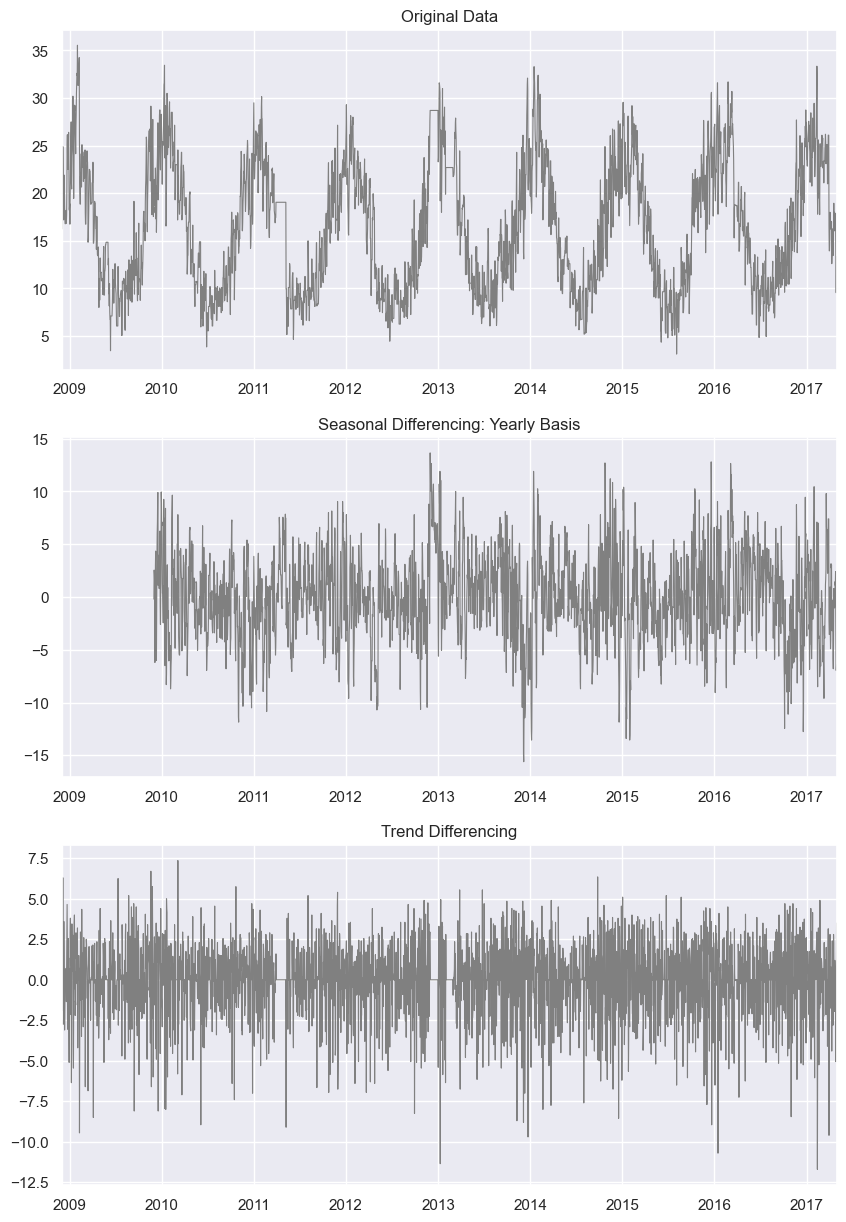

In [47]:
# 差分
plt.figure(figsize=(10,15))
plt.subplot(3, 1, 1)
df_albury_temp_train.plot(linewidth=0.8,color="gray")
plt.title("Original Data")
plt.subplot(3, 1, 2)
df_albury_temp_train_adj = df_albury_temp_train - df_albury_temp_train.shift(365)
df_albury_temp_train_adj.plot(linewidth=0.8,color="gray")
plt.title("Seasonal Differencing: Yearly Basis")
plt.subplot(3, 1, 3)
plt.title("Trend Differencing")
df_albury_temp_train_adj = df_albury_temp_train - df_albury_temp_train.shift(1)
df_albury_temp_train_adj.plot(linewidth=0.8,color="gray")

使用 Dickey-Fuller 检验来检验差分数据是否平稳： 
- 检验结果表明，检验的p值几乎为0即我们应当拒绝原假设
- 原假设被拒绝说明经过双重差分之后的时间序列模型是平稳的，可以再次基础上进一步建立SARIMAX模型

In [48]:
# ADF Test
result = adfuller(df_albury_temp_train_adj.dropna(), autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}') 

ADF Statistic: -23.118050821136286
n_lags: 0.0
p-value: 0.0
Critial Values:
   1%, -3.4324888216026417
Critial Values:
   5%, -2.862484996057603
Critial Values:
   10%, -2.5672730450894954


利用 ACF 和 PACF 来决定 SARIMAX(p,d,q)*(P,D,Q,S).

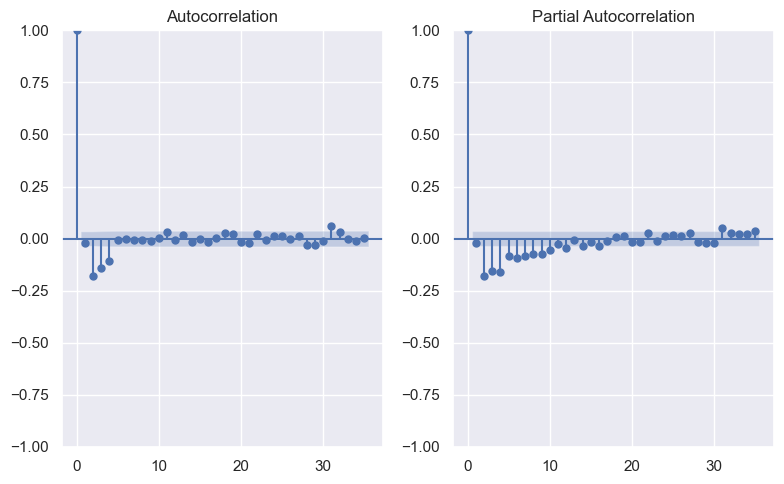

In [49]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))
plot_acf(df_albury_temp_train_adj.dropna(),ax=ax[0])
plot_pacf(df_albury_temp_train_adj.dropna(), ax=ax[1], method='ols')

plt.tight_layout()
plt.show()

拟合 SARIMAX(4,1,2)*(0,0,0,365) 模型

In [50]:
model = sm.tsa.statespace.SARIMAX(df_albury_temp_train,
                                order=(4, 1, 2),
                                seasonal_order=(0, 0, 0, 365),
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit()

In [51]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                AvgTemp   No. Observations:                 3073
Model:               SARIMAX(4, 1, 2)   Log Likelihood               -6617.166
Date:                Sun, 25 Jun 2023   AIC                          13248.331
Time:                        23:17:20   BIC                          13290.533
Sample:                    12-01-2008   HQIC                         13263.494
                         - 04-30-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0784      0.114     -0.688      0.491      -0.302       0.145
ar.L2          0.3924      0.088      4.480      0.000       0.221       0.564
ar.L3         -0.1488      0.030     -5.020      0.000      -0.207      -0.091
ar.L4         -0.0512      0.021     -2.467      0.014      -0.092      -0.011
ma.L1         -0.0469      0.114     -0.412      0.680      -0.270       0.176
ma.L2         -0.6631      0.099     -6.689      0.000      -0.857      -0.469
sigma2         4.3728      0.089     49.374      0.000       4.199       4.546
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               480.19
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.16   Skew:                            -0.63
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

    模型诊断：诊断显示温度分布有重尾，这可能是存在极端天气发生的指标。 因此，使用 t 分布建模可能是更好的选择，为了清晰的演示，我们将其省略。 除了正态性假设之外，该模型表现良好。

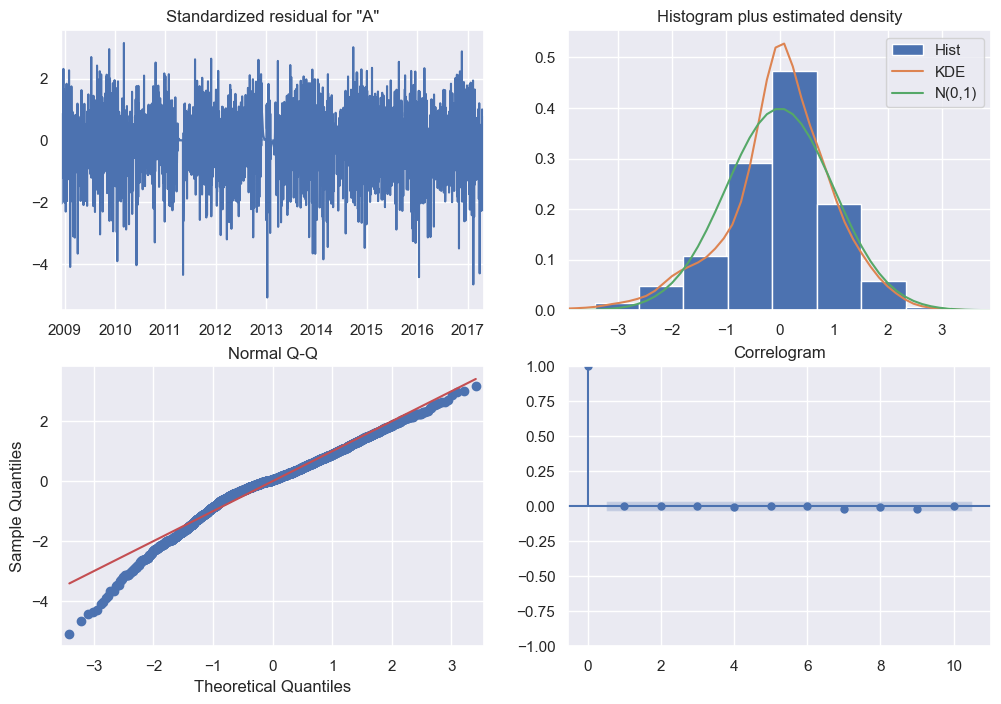

In [52]:
model.plot_diagnostics(figsize=(12, 8))
plt.show()

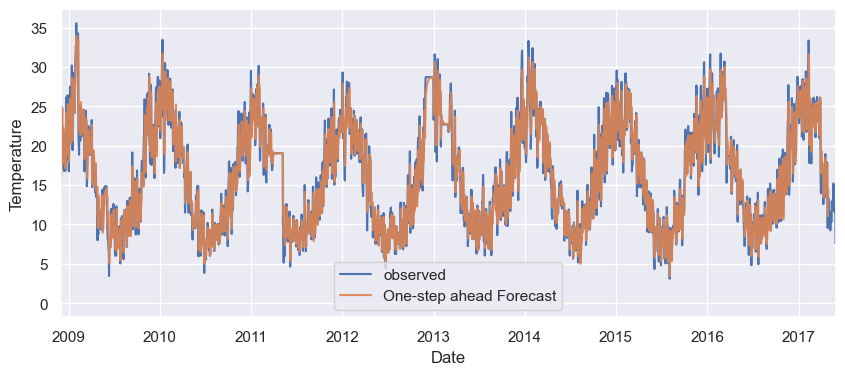

In [53]:
ax = df_albury_temp.loc[pd.to_datetime('2008-01-01'):pd.to_datetime('2017-05-30'),"AvgTemp"].plot(label='observed')
model.fittedvalues.plot(ax=ax, label='One-step ahead Forecast', alpha=.9, figsize=(10, 4))
ax.set_xlabel('Date')
ax.set_ylabel('Temperature')
plt.legend()
plt.show()

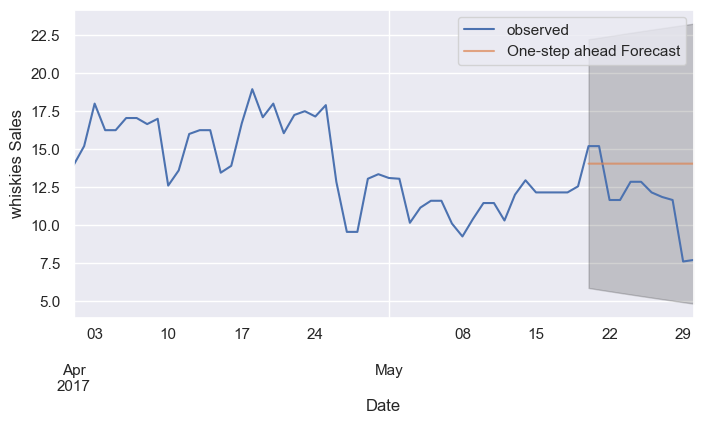

In [54]:
pred = model.get_prediction(start=pd.to_datetime('2017-05-20'), end=pd.to_datetime('2017-5-30'))
pred_ci = pred.conf_int()
ax = df_albury_temp.loc[pd.to_datetime('2017-04-01'):pd.to_datetime('2017-05-30'),"AvgTemp"].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(8, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('whiskies Sales')
plt.legend()
plt.show()

    我们注意到 SARIMA 模型的一个弱点是预测值在几个步骤中快速收敛到预期均值，这可能不足以预测几步之外的数据。 一种解决方案是按月对原始数据进行二次采样。

---

# Part3 降维可视化与ML&DL预测建模

In [55]:
#读取数据
data = pd.read_csv('./weather_data.csv').iloc[:,1:]

## 初步探索

In [56]:
data.head()

Date Location  MinTemp  MaxTemp  Rainfall WindGustDir  WindGustSpeed  \
0  2008/12/1   Albury     13.4     22.9       0.6           W           44.0   
1  2008/12/2   Albury      7.4     25.1       0.0         WNW           44.0   
2  2008/12/3   Albury     12.9     25.7       0.0         WSW           46.0   
3  2008/12/4   Albury      9.2     28.0       0.0          NE           24.0   
4  2008/12/5   Albury     17.5     32.3       1.0           W           41.0   

  WindDir9am WindDir3pm  WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  \
0          W        WNW          20.0          24.0         71.0         22.0   
1        NNW        WSW           4.0          22.0         44.0         25.0   
2          W        WSW          19.0          26.0         38.0         30.0   
3         SE          E          11.0           9.0         45.0         16.0   
4        ENE         NW           7.0          20.0         82.0         33.0   

   Pressure9am  Pressure3pm  Temp9am  Temp3pm  RainToday  RainTomorrow  
0       1007.7       1007.1     16.9     21.8        0.0           0.0  
1       1010.6       1007.8     17.2     24.3        0.0           0.0  
2       1007.6       1008.7     21.0     23.2        0.0           0.0  
3       1017.6       1012.8     18.1     26.5        0.0           0.0  
4       1010.8       1006.0     17.8     29.7        0.0           0.0

In [57]:
data.describe()

MinTemp        MaxTemp       Rainfall  WindGustSpeed  \
count  123710.000000  123710.000000  123710.000000  123710.000000   
mean       12.413834      23.476109       2.375661      40.685280   
std         6.366795       7.206175       8.528039      13.388636   
min        -8.500000      -4.800000       0.000000       7.000000   
25%         7.800000      18.100000       0.000000      31.000000   
50%        12.200000      23.000000       0.000000      39.000000   
75%        17.000000      28.600000       0.800000      48.000000   
max        33.900000      48.100000     367.600000     135.000000   

        WindSpeed9am   WindSpeed3pm    Humidity9am    Humidity3pm  \
count  123710.000000  123710.000000  123710.000000  123710.000000   
mean       15.011689      19.174578      67.558944      50.532854   
std         8.307285       8.571039      19.004197      21.030351   
min         2.000000       2.000000       0.000000       0.000000   
25%         9.000000      13.000000      56.000000      35.000000   
50%        13.000000      19.000000      68.000000      51.000000   
75%        20.000000      24.000000      81.000000      65.000000   
max        87.000000      87.000000     100.000000     100.000000   

         Pressure9am    Pressure3pm        Temp9am        Temp3pm  \
count  123710.000000  123710.000000  123710.000000  123710.000000   
mean     1016.916147    1014.532774      17.272213      21.917661   
std         6.977772       6.916309       6.478051       7.010518   
min       980.500000     977.100000      -7.200000      -5.400000   
25%      1011.400000    1008.900000      12.500000      16.800000   
50%      1016.700000    1014.300000      17.000000      21.500000   
75%      1021.700000    1019.300000      21.900000      26.700000   
max      1041.000000    1039.600000      40.200000      46.700000   

           RainToday   RainTomorrow  
count  123710.000000  123710.000000  
mean        0.224363       0.221421  
std         0.417164       0.415205  
min         0.000000       0.000000  
25%         0.000000       0.000000  
50%         0.000000       0.000000  
75%         0.000000       0.000000  
max         1.000000       1.000000

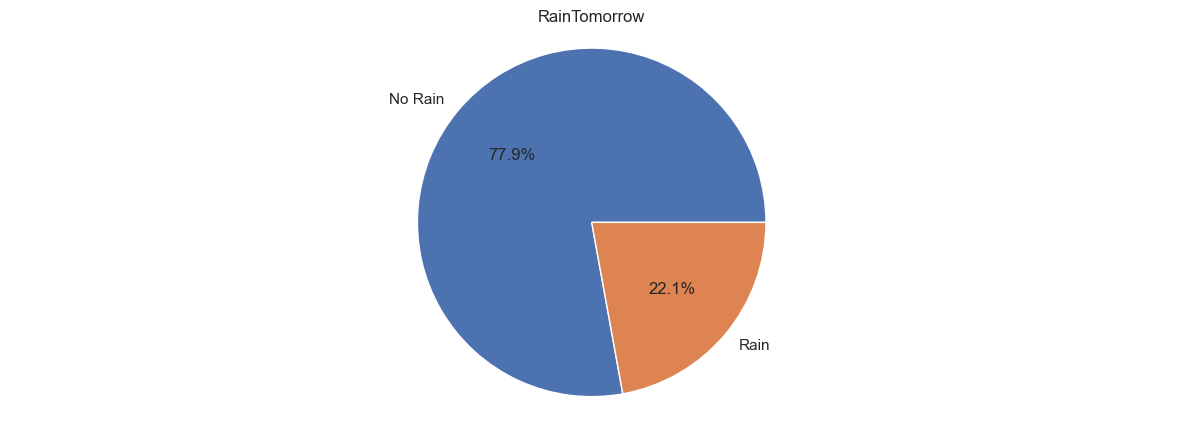

In [58]:
y=data['RainTomorrow']
rain_counts = data['RainTomorrow'].value_counts()

labels = ['No Rain', 'Rain']
counts = rain_counts.values

plt.pie(counts, labels=labels, autopct='%1.1f%%')
plt.axis('equal')  
plt.title('RainTomorrow')
plt.show()

## 特征工程与降维：
· 特征选取：由于此project中有特别的时间序列分析部分，此部分不特别将时间视为变量作相关分析;
· 同样地，地点在可视化中体现，不在此选作变量；
· 风向数据可以考虑进行编码，也可以不选作变量
· 考虑进行降维

#### 连续变量归一化处理:将连续变量进行归一化

In [59]:
X_cont = data.drop(columns=['Date','Location','WindGustDir','WindDir9am','WindDir3pm','RainTomorrow','RainToday'])

In [60]:
X_cont.head()

MinTemp  MaxTemp  Rainfall  WindGustSpeed  WindSpeed9am  WindSpeed3pm  \
0     13.4     22.9       0.6           44.0          20.0          24.0   
1      7.4     25.1       0.0           44.0           4.0          22.0   
2     12.9     25.7       0.0           46.0          19.0          26.0   
3      9.2     28.0       0.0           24.0          11.0           9.0   
4     17.5     32.3       1.0           41.0           7.0          20.0   

   Humidity9am  Humidity3pm  Pressure9am  Pressure3pm  Temp9am  Temp3pm  
0         71.0         22.0       1007.7       1007.1     16.9     21.8  
1         44.0         25.0       1010.6       1007.8     17.2     24.3  
2         38.0         30.0       1007.6       1008.7     21.0     23.2  
3         45.0         16.0       1017.6       1012.8     18.1     26.5  
4         82.0         33.0       1010.8       1006.0     17.8     29.7

In [61]:
sc = StandardScaler()
sc.fit(X_cont)
X_cont_std = sc.transform(X_cont)

In [62]:
y=data['RainTomorrow']

#### 分别对正负样本进行密度函数可视化

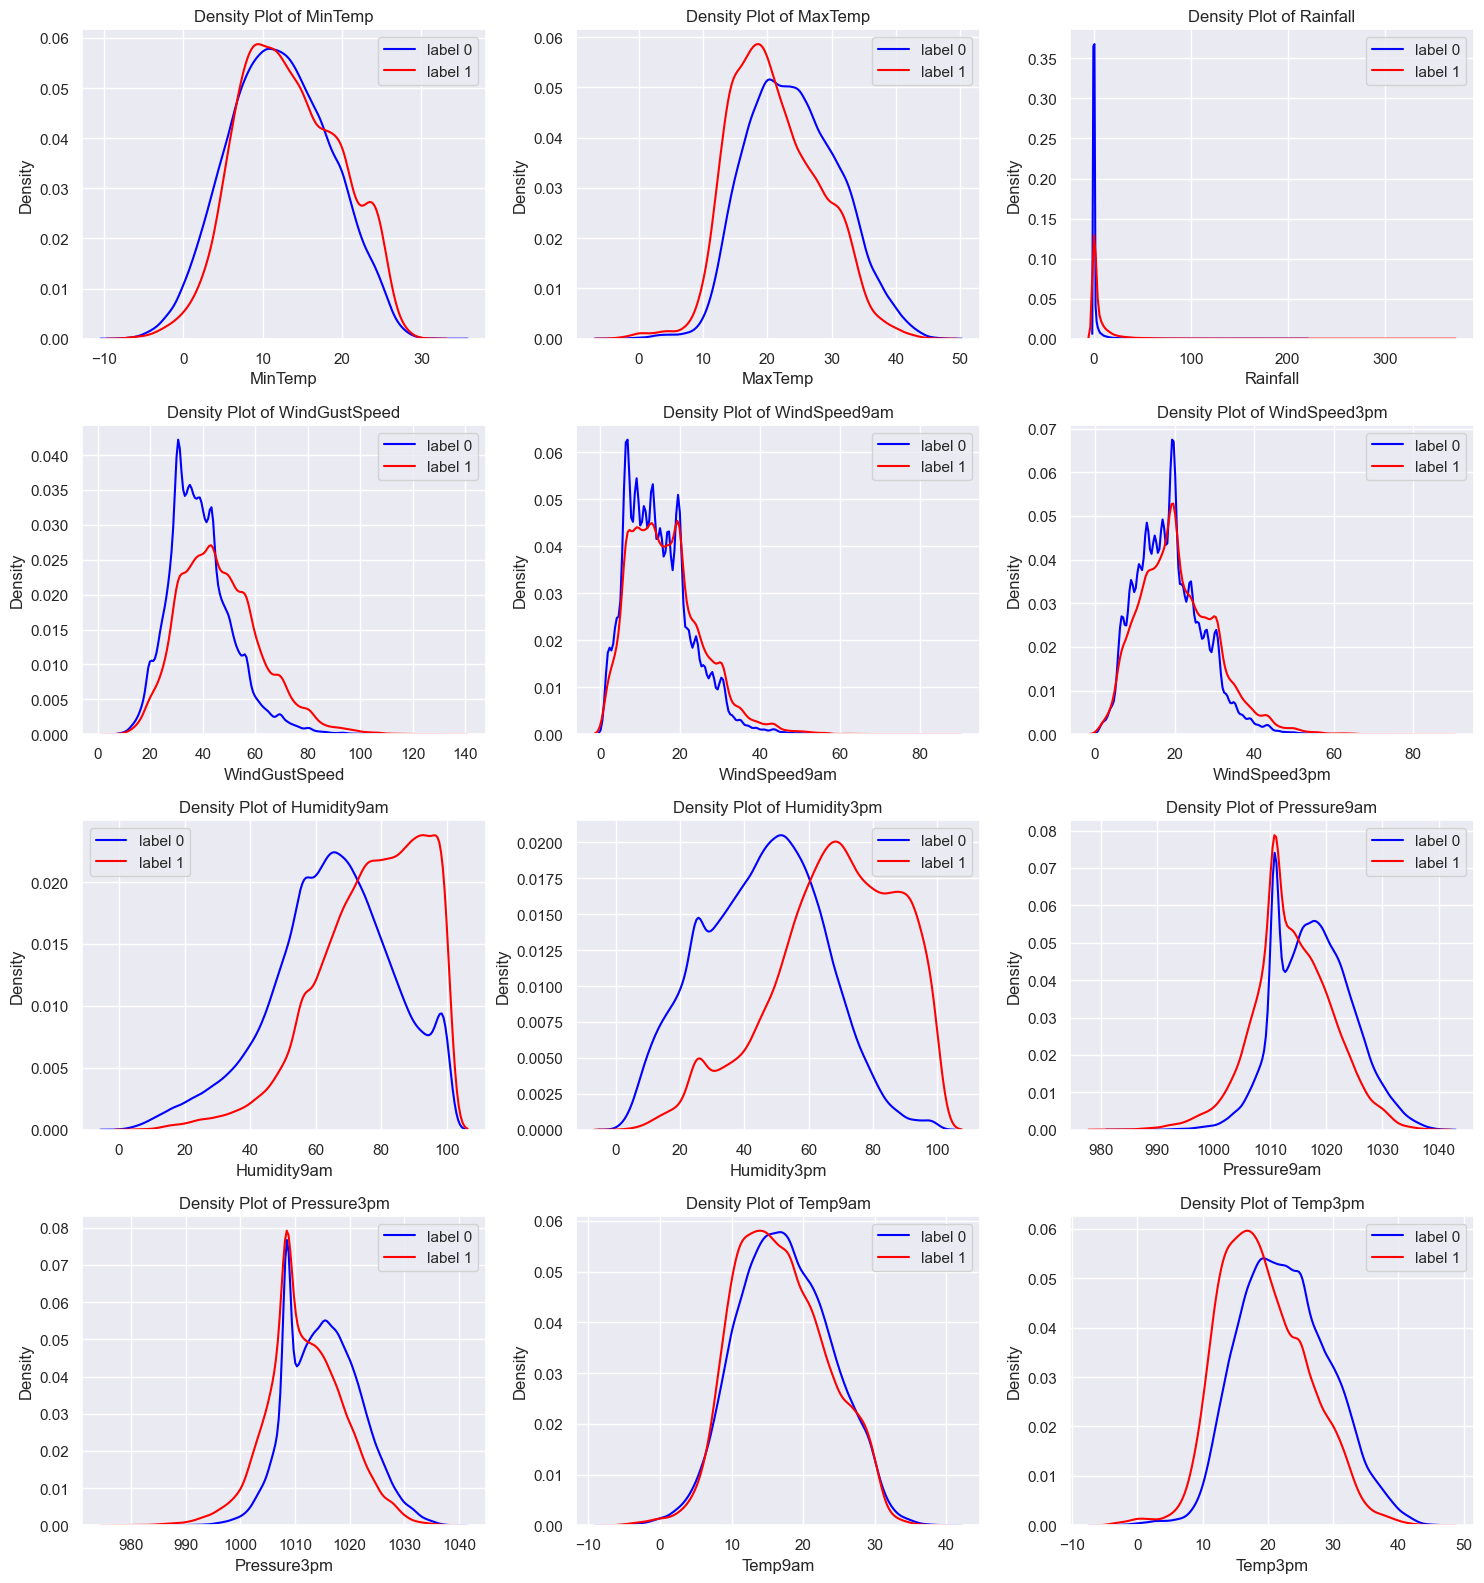

In [63]:
XX_cont = X_cont.copy()
XX_cont['label'] = y
neg = XX_cont.loc[XX_cont['label'] == 0]
pos = XX_cont.loc[XX_cont['label'] == 1]

columns = XX_cont.columns
num_rows = 4  
num_cols = 3  
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 4*num_rows))

for idx, column in enumerate(columns):
    if column == 'label':
        continue
    
    row_idx = idx // num_cols  
    col_idx = idx % num_cols  

    ax = axes[row_idx, col_idx]
    sns.kdeplot(neg[column], label='label 0', color='blue', ax=ax)
    sns.kdeplot(pos[column], label='label 1', color='red', ax=ax)
    ax.set_title(f"Density Plot of {column}")
    ax.legend()

for i in range(len(columns), num_rows*num_cols):
    row_idx = i // num_cols
    col_idx = i % num_cols
    fig.delaxes(axes[row_idx, col_idx])

plt.tight_layout()
plt.show()

In [64]:
X = data.drop(columns=['Date','RainTomorrow'])
X[['MinTemp','MaxTemp','Rainfall','WindGustSpeed','WindSpeed9am','WindSpeed3pm','Humidity9am','Humidity3pm','Pressure9am','Pressure3pm','Temp9am','Temp3pm']]=X_cont_std

#### 类别变量编码

此处首先需要处理的是Location变量。实际意义在于，在其他条件相同的情况下，某一城市明天是否下雨的概率显著更高。因此适合使用Target Encoding

In [65]:
X_Location = data.groupby('Location')['RainTomorrow'].mean()
X['Location'] = X['Location'].map(X_Location)

其次是各个风向数据，不同风向之间存在相近关系，因此采取正余弦函数编码的方式进行编码。

In [66]:
##风向正余弦编码
def encode_wind_direction(wind_direction): 
    angles = np.arange(0, 2 * np.pi, 2 * np.pi / 16) 
    directions = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW'] 
    angle = angles[directions.index(wind_direction)] 
    return np.cos(angle), np.sin(angle) # 创建新的列来存储编码后的风向 
X['WindGustDir Cos'], X['WindGustDir Sin'] = zip(*X['WindGustDir'].map(encode_wind_direction))
X['WindDir9am Cos'], X['WindDir9am Sin'] = zip(*X['WindDir9am'].map(encode_wind_direction))
X['WindDir3pm Cos'], X['WindDir3pm Sin'] = zip(*X['WindDir3pm'].map(encode_wind_direction))

In [67]:
X=X.drop(['WindGustDir','WindDir9am','WindDir3pm'],axis=1)
X

Location   MinTemp   MaxTemp  Rainfall  WindGustSpeed  WindSpeed9am  \
0       0.216360  0.154893 -0.079947 -0.208215       0.247578      0.600477   
1       0.216360 -0.787500  0.225348 -0.278572       0.247578     -1.325551   
2       0.216360  0.076360  0.308610 -0.278572       0.396959      0.480100   
3       0.216360 -0.504783  0.627782 -0.278572      -1.246232     -0.482914   
4       0.216360  0.798861  1.224495 -0.161311       0.023507     -0.964421   
...          ...       ...       ...       ...            ...           ...   
123705  0.076072 -1.400056 -0.232594 -0.278572      -0.723399     -0.001407   
123706  0.076072 -1.510002 -0.010562 -0.278572      -0.723399     -0.242161   
123707  0.076072 -1.384349  0.253102 -0.278572      -1.395613     -0.242161   
123708  0.076072 -1.101632  0.475135 -0.278572      -0.275255     -0.723668   
123709  0.076072 -0.724674  0.489012 -0.278572      -0.947470     -0.242161   

        WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  Pressure3pm  \
0           0.562994     0.181069    -1.356752    -1.320792    -1.074678   
1           0.329649    -1.239676    -1.214100    -0.905185    -0.973467   
2           0.796339    -1.555397    -0.976348    -1.335123    -0.843340   
3          -1.187093    -1.187055    -1.642055     0.098005    -0.250536   
4           0.096304     0.759891    -0.833696    -0.876522    -1.233723   
...              ...          ...          ...          ...          ...   
123705     -0.720403    -0.450373    -1.118999     1.115526     0.963990   
123706     -0.953748    -0.871334    -1.261651     1.101194     0.833862   
123707     -1.187093    -0.608234    -1.404302     0.943550     0.660359   
123708     -1.187093    -0.766094    -1.261651     0.585268     0.327810   
123709     -1.420438    -0.871334    -1.261651     0.355968     0.284434   

         Temp9am   Temp3pm  RainToday  WindGustDir Cos  WindGustDir Sin  \
0      -0.057458 -0.016784        0.0    -1.836970e-16        -1.000000   
1      -0.011147  0.339825        0.0     3.826834e-01        -0.923880   
2       0.575451  0.182917        0.0    -3.826834e-01        -0.923880   
3       0.127784  0.653640        0.0     7.071068e-01         0.707107   
4       0.081473  1.110099        0.0    -1.836970e-16        -1.000000   
...          ...       ...        ...              ...              ...   
123705 -1.215218 -0.145163        0.0     6.123234e-17         1.000000   
123706 -1.107161  0.068802        0.0     6.123234e-17         1.000000   
123707 -0.983666  0.368354        0.0     9.238795e-01        -0.382683   
123708 -0.736677  0.596583        0.0     1.000000e+00         0.000000   
123709 -0.335320  0.582319        0.0    -7.071068e-01         0.707107   

        WindDir9am Cos  WindDir9am Sin  WindDir3pm Cos  WindDir3pm Sin  
0        -1.836970e-16       -1.000000    3.826834e-01       -0.923880  
1         9.238795e-01       -0.382683   -3.826834e-01       -0.923880  
2        -1.836970e-16       -1.000000   -3.826834e-01       -0.923880  
3        -7.071068e-01        0.707107    6.123234e-17        1.000000  
4         3.826834e-01        0.923880    7.071068e-01       -0.707107  
...                ...             ...             ...             ...  
123705   -3.826834e-01        0.923880    6.123234e-17        1.000000  
123706   -7.071068e-01        0.707107    3.826834e-01        0.923880  
123707   -7.071068e-01        0.707107    1.000000e+00        0.000000  
123708   -7.071068e-01        0.707107    3.826834e-01       -0.923880  
123709   -9.238795e-01        0.382683    1.000000e+00        0.000000  

[123710 rows x 20 columns]

### 画出归一化处理后的相关矩阵，

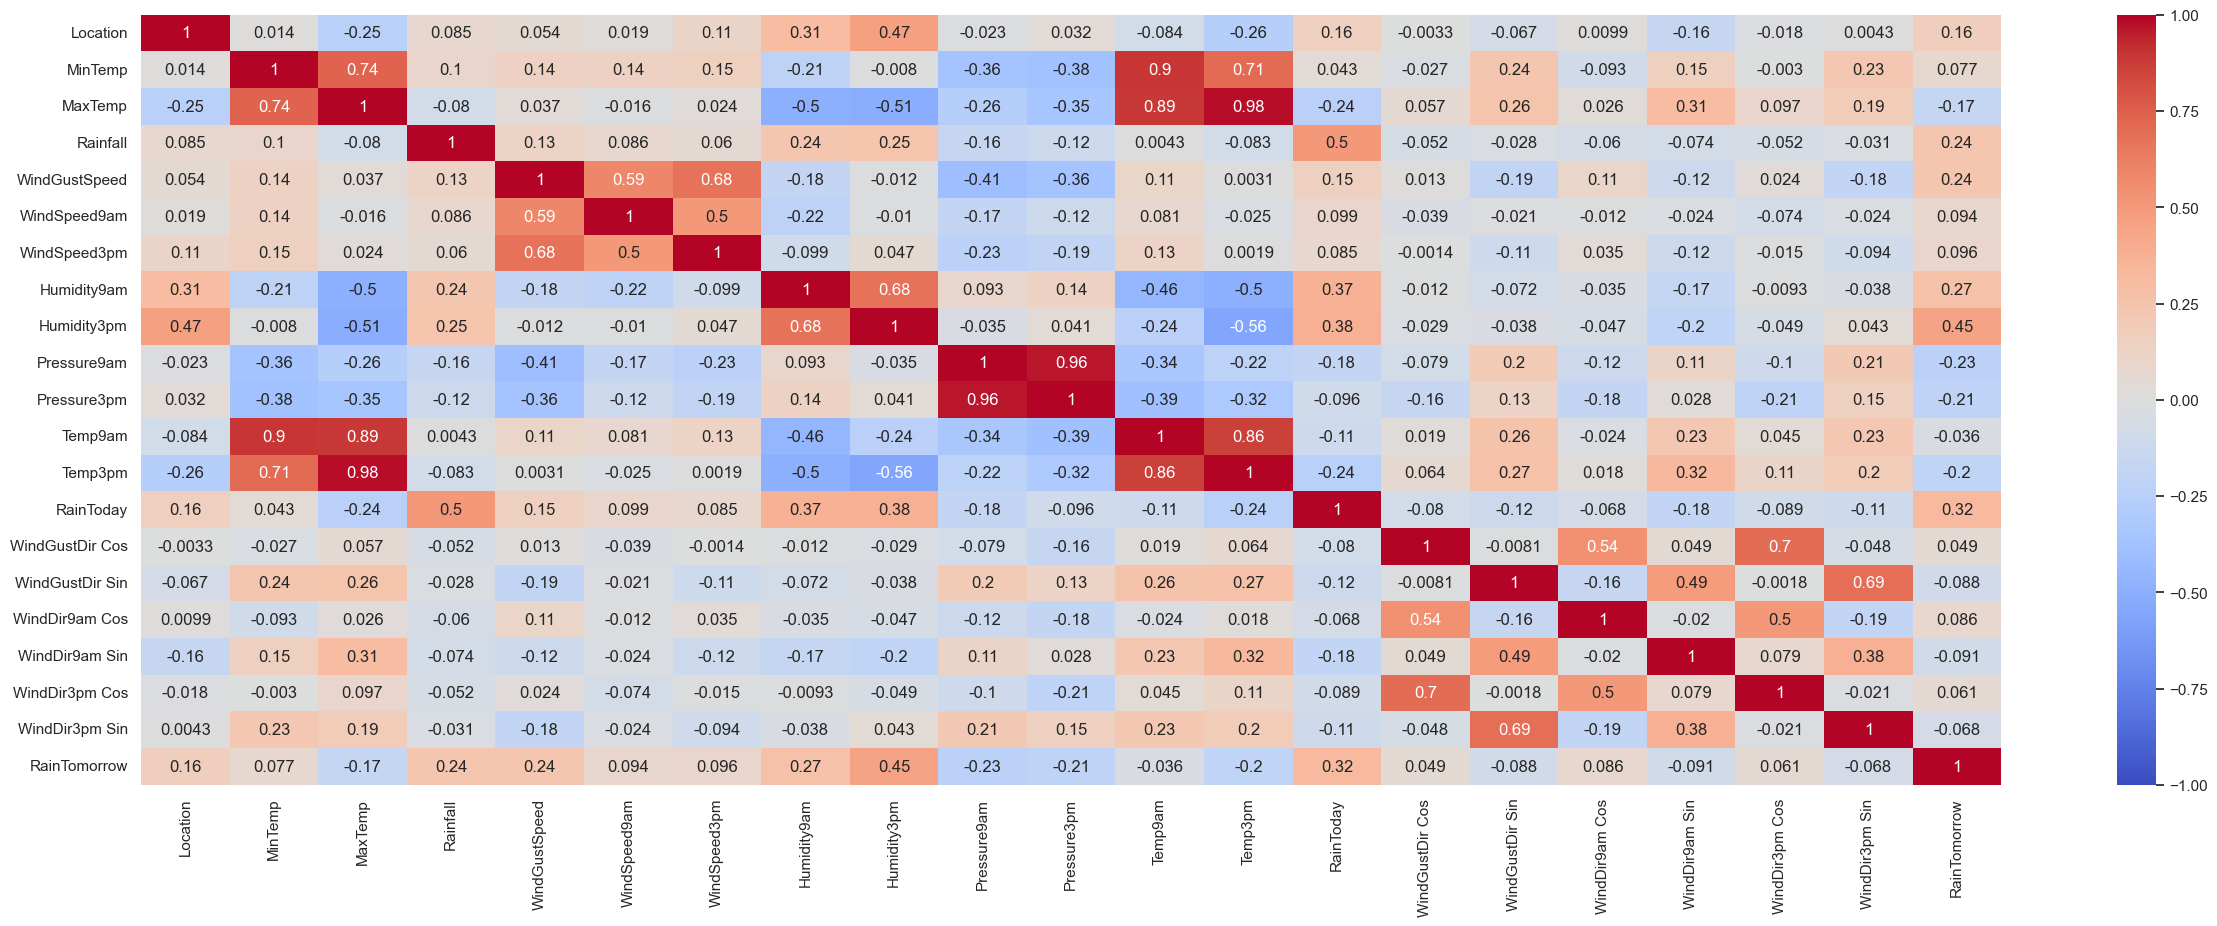

In [68]:
XX=X.copy()
XX['RainTomorrow']=y
corr = XX.corr()
plt.figure(figsize=(30, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm',vmin=-1, vmax=1)
plt.show()

#### 结论：根据这个相关系数矩阵可知，
1. 各个变量之间存在一定多重共线性，例如地理位置与湿度、最低温度与最高温度有强相关性等等，因此可以尝试对特征进行降维。
2. 对于目标变量，自变量与其的相关系数差异较大，存在部分变量对目标变量影响较小，可以考虑特征选择。

### 降维可视化

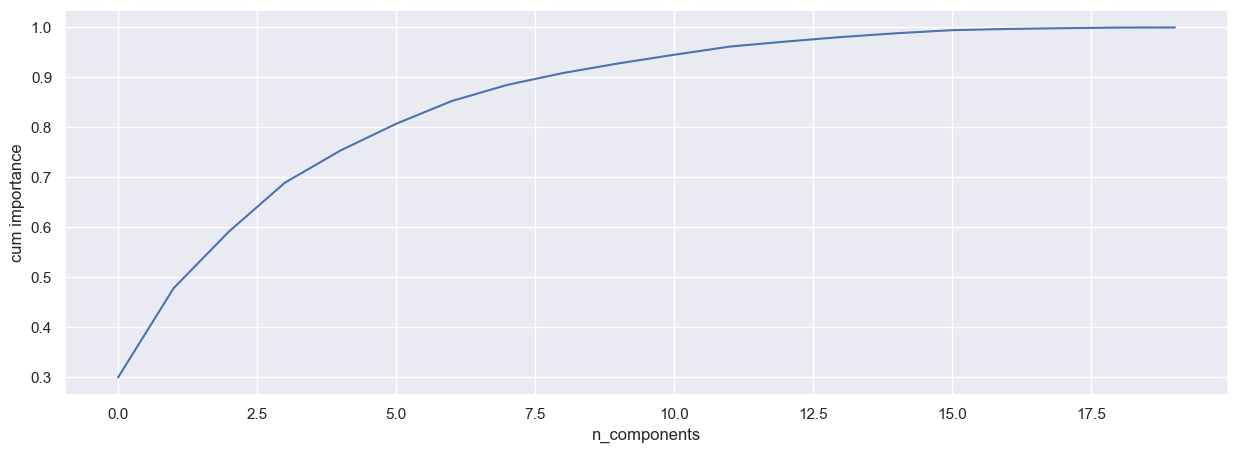

In [69]:
pca=PCA().fit(X)
cum_var = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cum_var)
plt.xlabel("n_components")
plt.ylabel("cum importance")
plt.show()

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

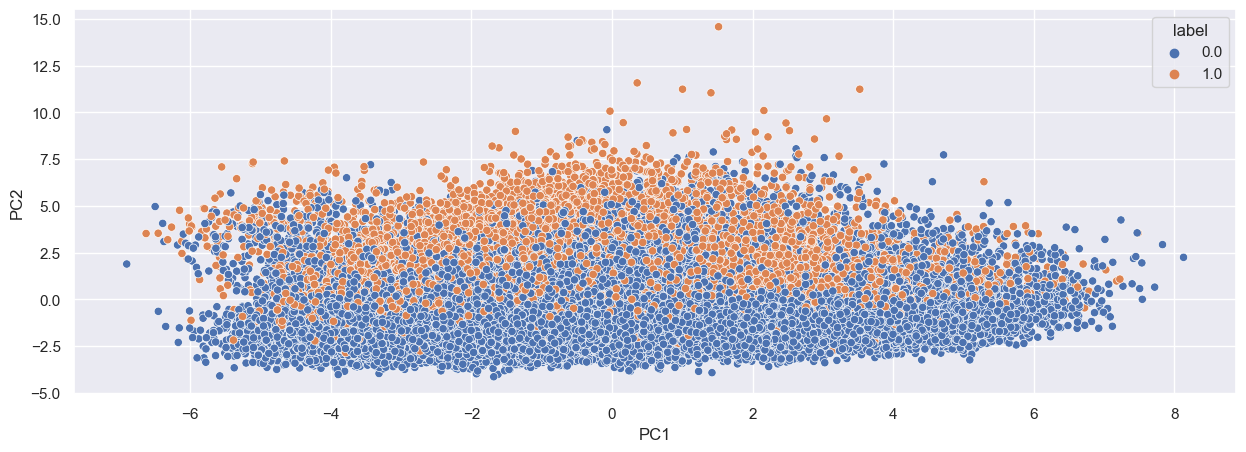

In [70]:
#根据上图，2个主成分的效果应该一般
pca_data = PCA(2).fit_transform(X)
dr=pd.DataFrame()
dr['label']=y
dr['PC1']=pca_data[:,0]
dr['PC2']=pca_data[:,1]
sns.scatterplot(data=dr,x='PC1',y='PC2',hue='label',palette='deep')

对于该问题，难以降维到二维，实际上，根据方差解释程度图，应当选择8个主成分，因此应当考虑其他降维方式。

### 用MDS降维可视化

In [71]:
#数据量过于庞大，由于是可视化不是训练，可以只选取部分进行可视化
X_simple=X.head(2000)
mds=manifold.MDS(2)
mds_data=mds.fit_transform(X_simple)

<AxesSubplot:xlabel='d1', ylabel='d2'>

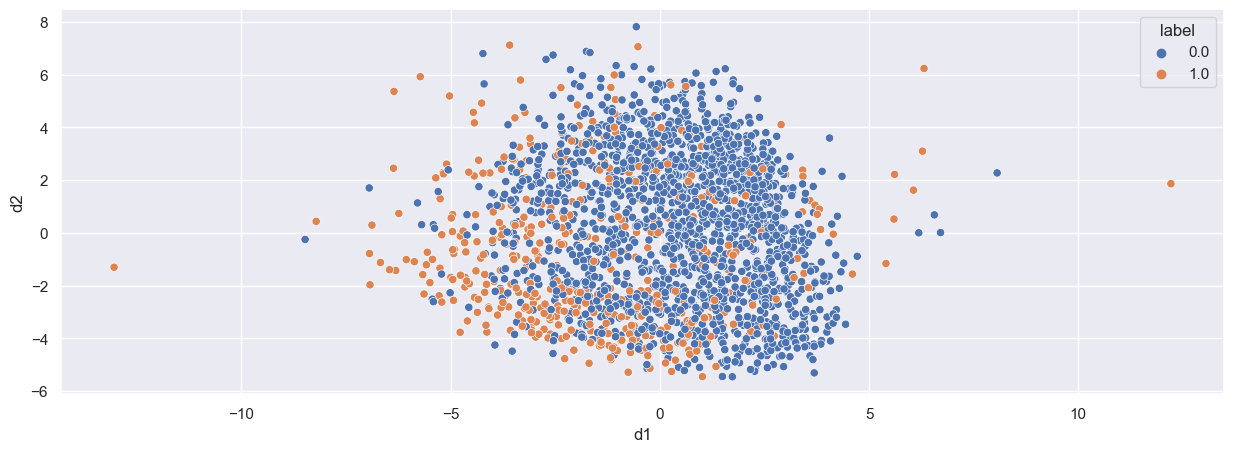

In [72]:
dr1=dr.iloc[0:2000]
dr1['d1']=mds_data[:,0]
dr1['d2']=mds_data[:,1]
sns.scatterplot(data=dr1,x='d1',y='d2',hue='label',palette='deep')

分离度仍然一般，继续考虑其他方法

### 用LLE降维

<AxesSubplot:xlabel='l1', ylabel='l2'>

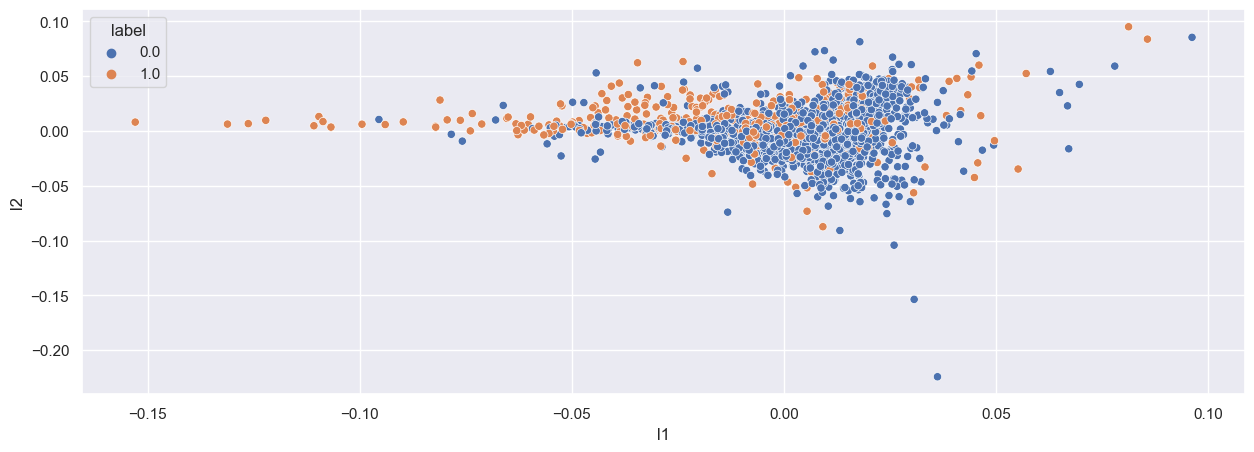

In [73]:
lle = manifold.LocallyLinearEmbedding(n_neighbors=10,n_components=2)
data_lle=lle.fit_transform(X_simple)
dr1['l1']=data_lle[:,0]
dr1['l2']=data_lle[:,1]
sns.scatterplot(data=dr1,x='l1',y='l2',hue='label',palette='deep')

分离结果仍有改进空间，继续采用其他方法

### 用Laplacian Eigenmaps降维

<AxesSubplot:xlabel='lap1', ylabel='lap2'>

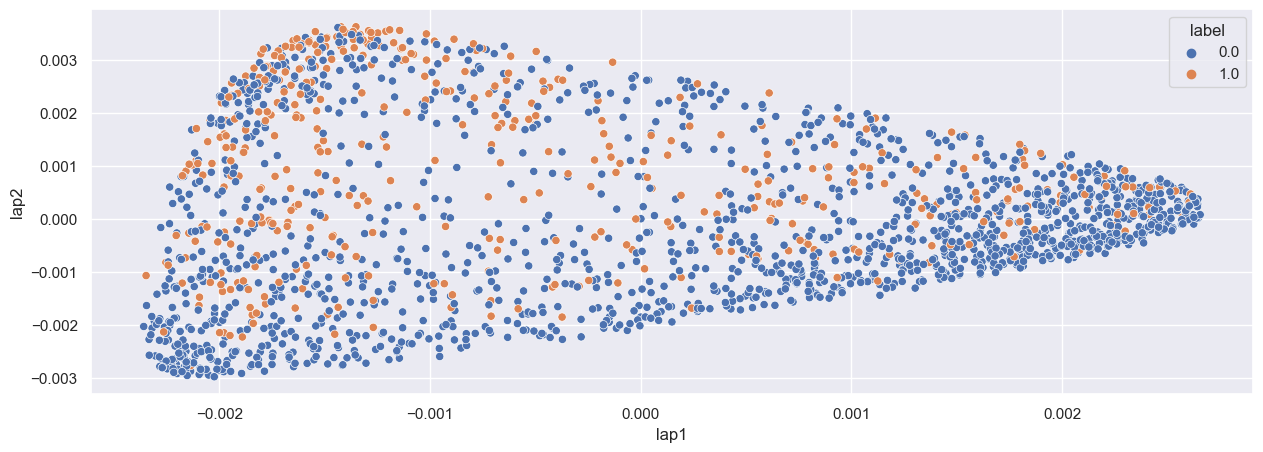

In [74]:
embedding = SpectralEmbedding(n_components = 2)
data_laplace = embedding.fit_transform(X_simple)
dr1['lap1'] = data_laplace[:,0]
dr1['lap2'] = data_laplace[:,1]
sns.scatterplot(data=dr1,x='lap1',y='lap2',hue='label',palette='deep')

效果一般

### 用t-SNE降维

<AxesSubplot:xlabel='tsne1', ylabel='tsne2'>

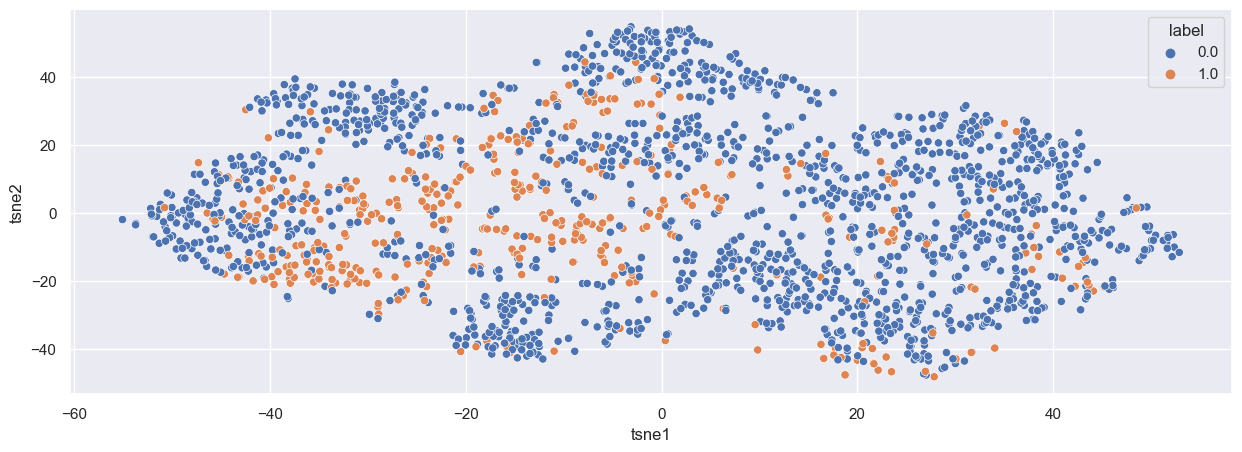

In [75]:
ebd = TSNE(n_components=2)
data_tsne = ebd.fit_transform(X_simple)
dr1['tsne1'] = data_tsne[:,0]
dr1['tsne2'] = data_tsne[:,1]
sns.scatterplot(data=dr1,x='tsne1',y='tsne2',hue='label',palette='deep')

### 总结：从上述结果可见:
1. t-SNE是这组结果中可视化表现较好的方法，在tsne的结果中，分类效果明显，能够且保留原始高维数据中的结构。
2. PCA显而易见效果还不错，尽管能够做到一定程度的分类，但散点都簇拥在图的中间，但相比其他方法，其计算速度较快，复杂度较低。
3. MDS降维效果一般，只能保留相对距离，且计算复杂度高，耗时长。
4. LLE和Laplace Eigenmap都有还行的降维效果呈现，但也有各自的问题：在保留原始数据整体结构的能力上有所欠缺，不如t-SNE。
5. 由于多种方法都无法有效分离两种样本，该数据集的负样本与正样本在二维空间里的可能需要较为复杂的模型来进行分析。

### 基于RFE的特征选择

In [76]:
##分割训练集与测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
feature_names = X_train.columns
##rfe进行变量选择
model_rfe = LogisticRegression()
##根据pca结果，选择6-8个特征为宜,这里选择7个
rfe = RFE(estimator=model_rfe, n_features_to_select=7)
X_selected = rfe.fit_transform(X_train, y_train)
selected_mask = rfe.support_
selected_features = feature_names[selected_mask]
print(selected_features)

Index(['Location', 'WindGustSpeed', 'WindSpeed3pm', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'RainToday'],
      dtype='object')


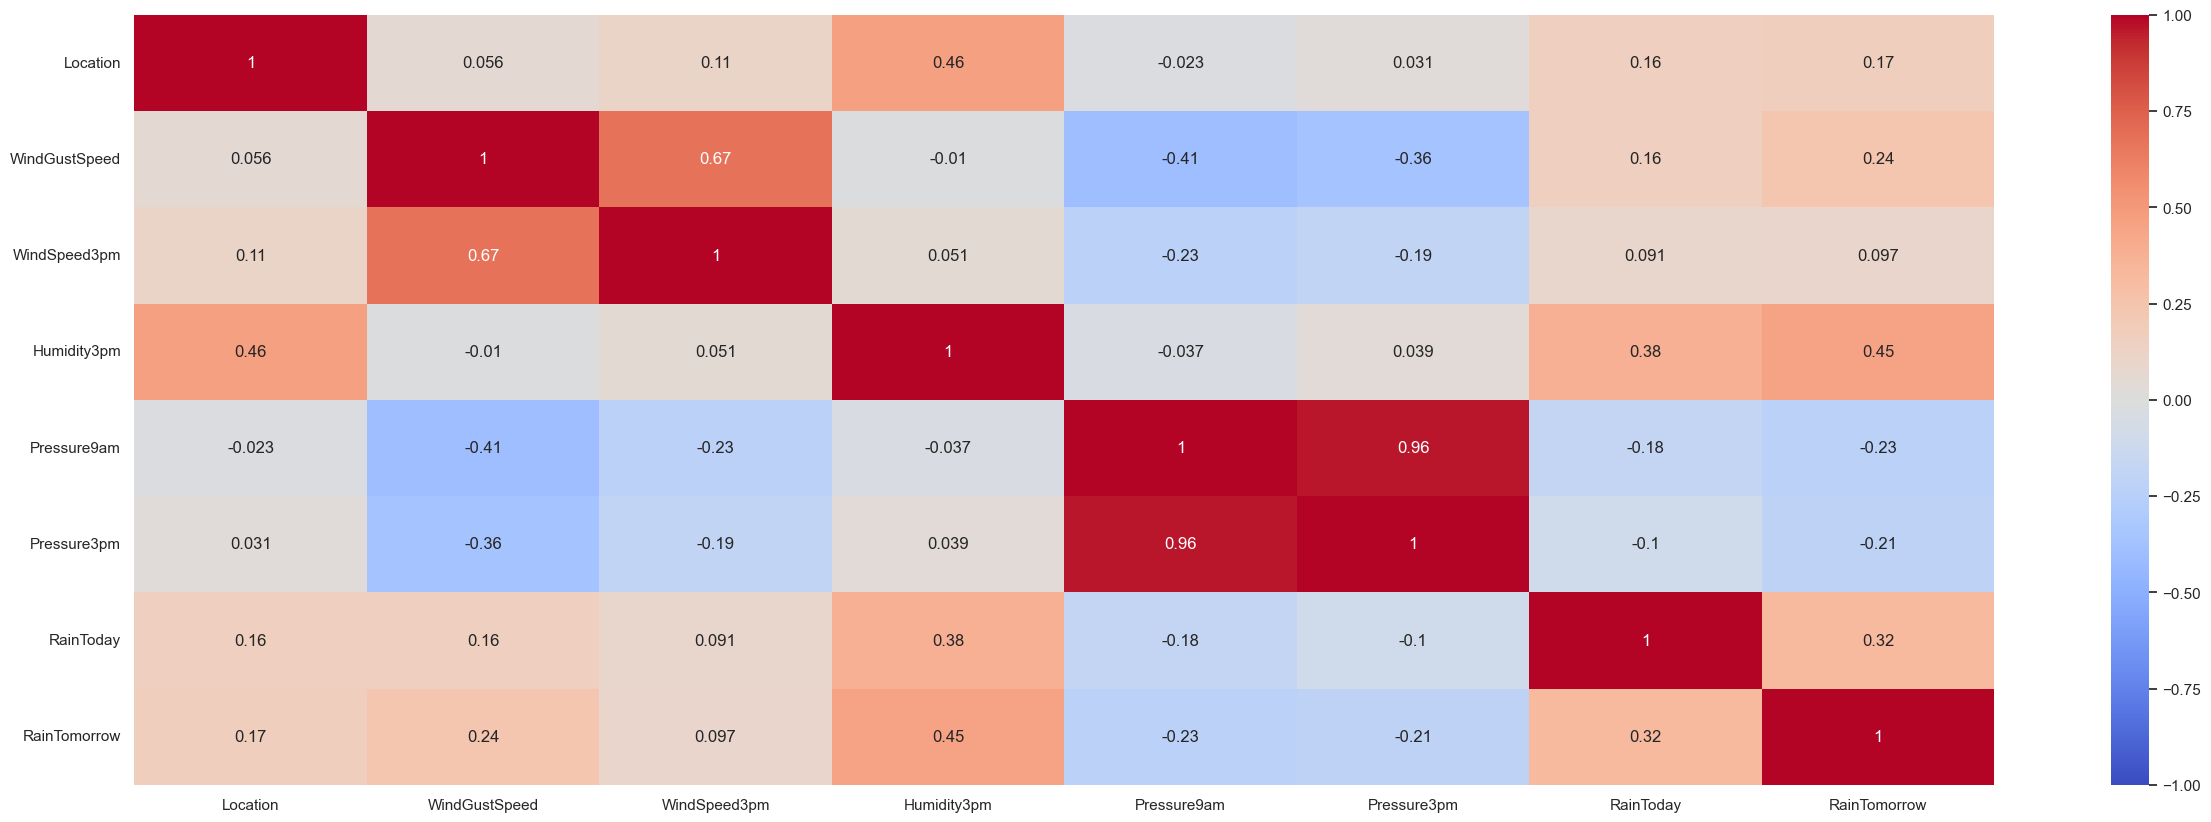

In [77]:
X_train_rfe = X_train[selected_features]
X_test_rfe = X_test[selected_features]
XX_rfe=X_train_rfe.copy()
XX_rfe['RainTomorrow']=y
corr = XX_rfe.corr()
plt.figure(figsize=(30, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm',vmin=-1, vmax=1)
plt.show()

可见多重共线性已缓解，且选择的变量与目标变量相关性都较高。

## ML方法搭建Classifier
### LogisticRegression

In [78]:
model1 =LogisticRegression()
model1.fit(X_train_rfe,y_train)
y_pred_1 = model1.predict(X_test_rfe)
print('overall accuracy:',model1.score(X_test_rfe,y_test))

overall accuracy: 0.8425619055317544


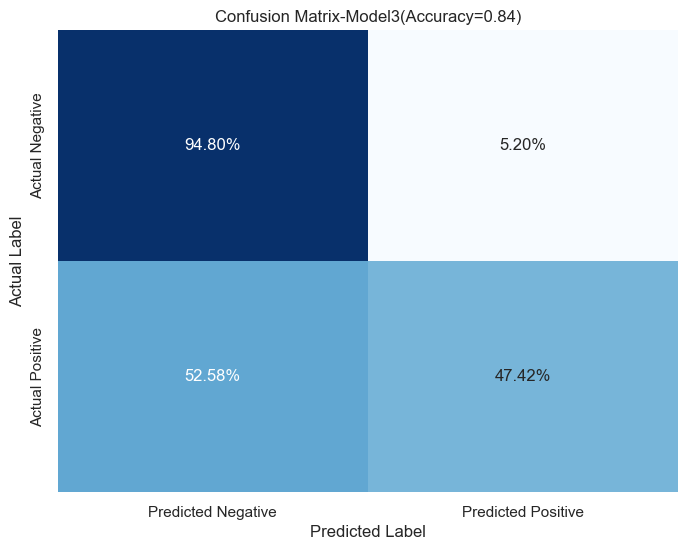

                 Predicted Negative  Predicted Positive
Actual Negative               27355                1502
Actual Positive                4341                3915
Precision: 0.7227247553996677 recall: 0.4742005813953488


In [79]:
##画出confusion matrix
cm = confusion_matrix(y_test, y_pred_1)
class_totals = cm.sum(axis=1, keepdims=True)

normalized_cm = cm / class_totals

df_confusion_matrix = pd.DataFrame(normalized_cm, columns=['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive'])

plt.figure(figsize=(8, 6))
sns.heatmap(df_confusion_matrix, annot=True, cmap='Blues', fmt='.2%', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix-Model3(Accuracy={:.2f})'.format(model1.score(X_test_rfe,y_test)))
plt.show()
df_cm = pd.DataFrame(cm, index=['Actual Negative','Actual Positive'], columns=['Predicted Negative','Predicted Positive'])
print(df_cm)

true_positive = df_cm.at['Actual Positive', 'Predicted Positive']
false_positive = df_cm.at['Actual Negative', 'Predicted Positive']
false_negative = df_cm.at['Actual Positive', 'Predicted Negative']

precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)

print('Precision:',precision,'recall:',recall)

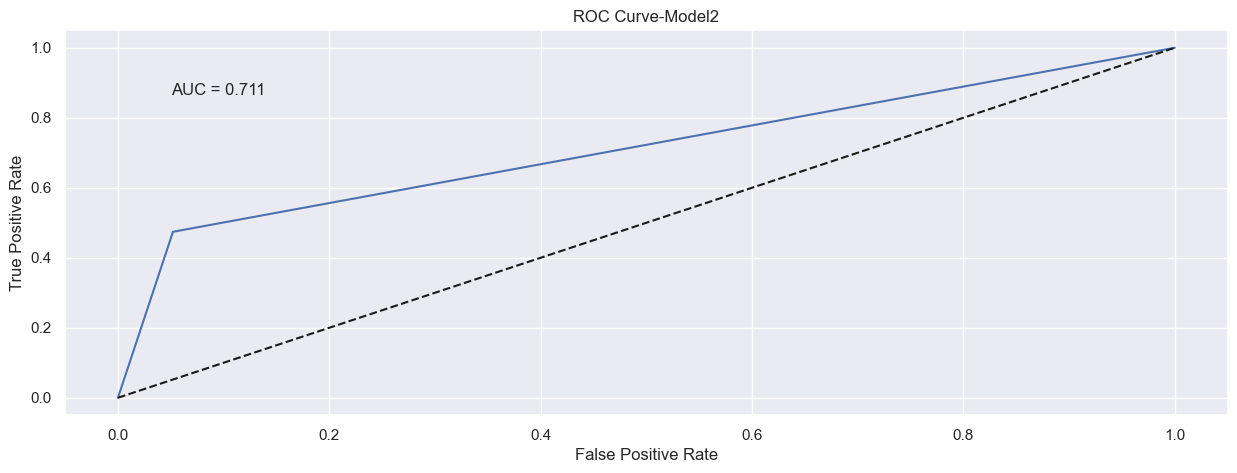

auc: 0.7110754093863808


In [80]:
auc_model1 = roc_auc_score(y_test, y_pred_1)
y_scores_1 = model1.decision_function(X_test_rfe)
y_true_binary = label_binarize(y_test, classes=[0, 1])
fpr, tpr, thresholds = roc_curve(y_test, y_pred_1)
plt.plot(fpr, tpr,label='AUC = {:.2f}'.format(auc_model1))
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')
plt.text(0.05, 0.9, 'AUC = {:.3f}'.format(auc_model1), fontsize=12,va='top')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve-Model2')

plt.show()
print('auc:',auc_model1)

模型的总体正确率较高，达到84%，但auc较为一般，只有71%，说明模型在两类样本的平衡性上不够优秀，可作为baseline。可以尝试添加权重。

In [81]:
model2 =LogisticRegression(class_weight={0:1,1:3})
model2.fit(X_train_rfe,y_train)
y_pred_2 = model2.predict(X_test_rfe)
print('overall accuracy:',model2.score(X_test_rfe,y_test))

overall accuracy: 0.8006358957777598


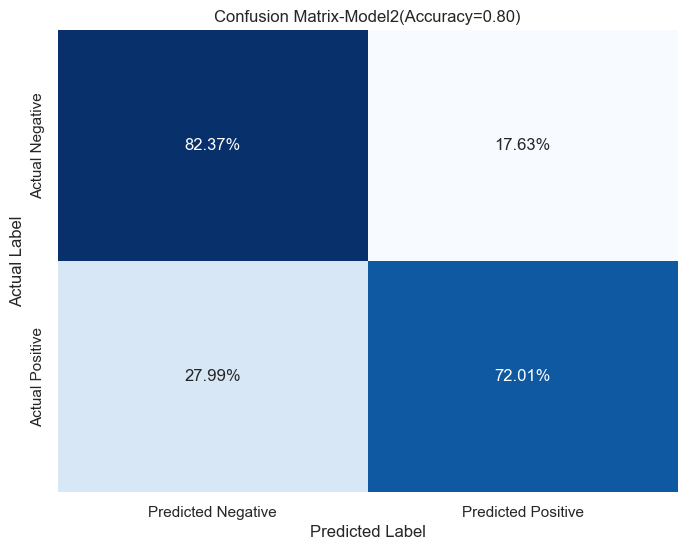

                 Predicted Negative  Predicted Positive
Actual Negative               23769                5088
Actual Positive                2311                5945
Precision: 0.538838031360464 recall: 0.7200823643410853


In [82]:
cm = confusion_matrix(y_test, y_pred_2)
class_totals = cm.sum(axis=1, keepdims=True)


normalized_cm = cm / class_totals


df_confusion_matrix = pd.DataFrame(normalized_cm, columns=['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive'])

plt.figure(figsize=(8, 6))
sns.heatmap(df_confusion_matrix, annot=True, cmap='Blues', fmt='.2%', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix-Model2(Accuracy={:.2f})'.format(model2.score(X_test_rfe,y_test)))
plt.show()
df_cm = pd.DataFrame(cm, index=['Actual Negative','Actual Positive'], columns=['Predicted Negative','Predicted Positive'])
print(df_cm)

true_positive = df_cm.at['Actual Positive', 'Predicted Positive']
false_positive = df_cm.at['Actual Negative', 'Predicted Positive']
false_negative = df_cm.at['Actual Positive', 'Predicted Negative']

precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)

print('Precision:',precision,'recall:',recall)

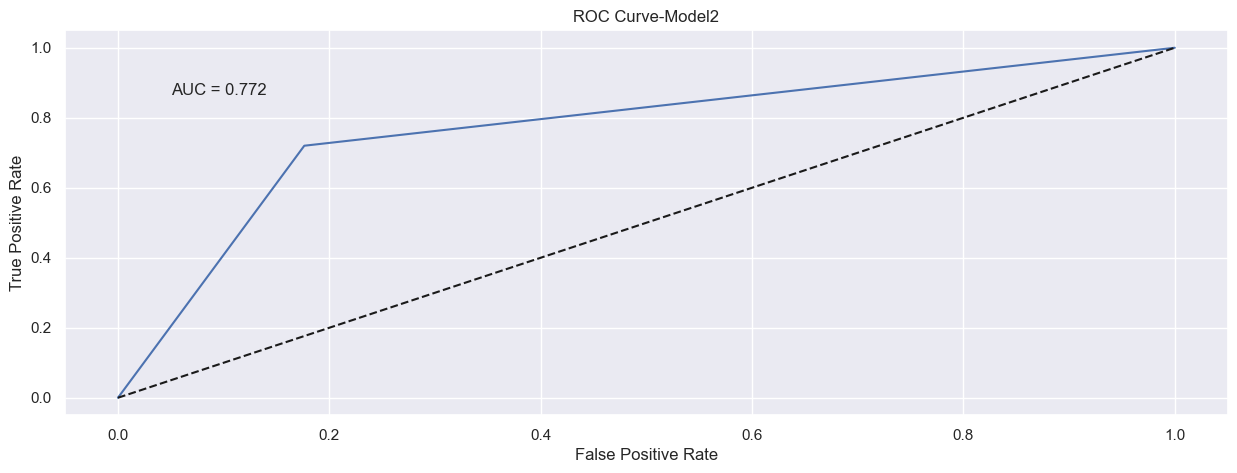

auc: 0.7718823298989967


In [83]:
##画出ROC曲线
auc_model2 = roc_auc_score(y_test, y_pred_2)
y_scores_2 = model2.decision_function(X_test_rfe)
y_true_binary = label_binarize(y_test, classes=[0, 1])
fpr, tpr, thresholds = roc_curve(y_test, y_pred_2)
plt.plot(fpr, tpr,label='AUC = {:.2f}'.format(auc_model2))
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')
plt.text(0.05, 0.9, 'AUC = {:.3f}'.format(auc_model2), fontsize=12,va='top')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve-Model2')

plt.show()
print('auc:',auc_model2)

这个模型的总体准确率相较baseline有所降低，但是其对于正样本，即明天会下雨的预测能力提升了，auc也达到了77%。

#### 对逻辑回归结果中各自变量的系数进行可视化，作为对明日下雨影响因素的正负性与影响程度大小的参考

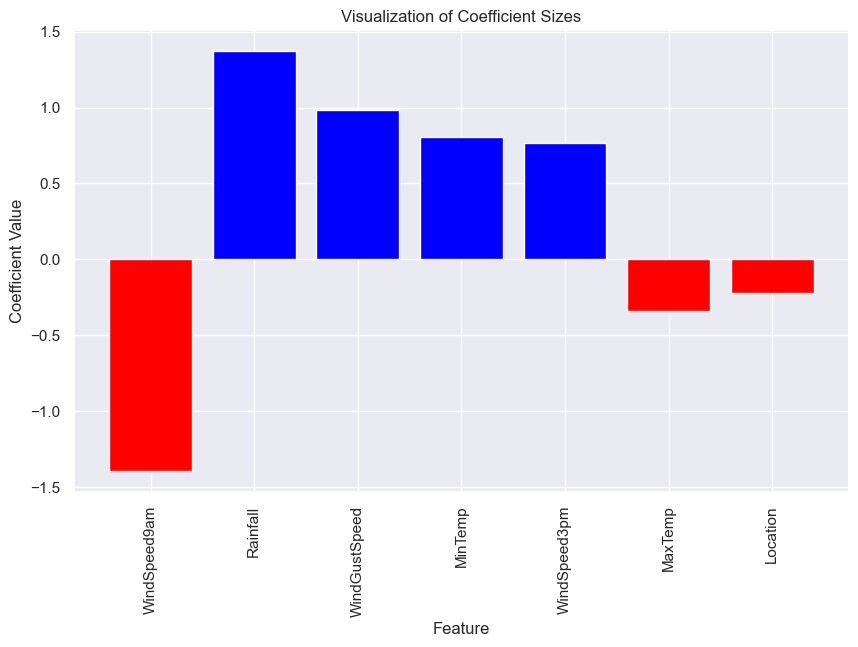

In [84]:

coefficients = model2.coef_[0]
features=X_train_rfe.columns
features_names = list(features)
abs_coefficients = np.abs(coefficients)

coefficients_list = list(zip(feature_names, coefficients, abs_coefficients))

sorted_coefficients = sorted(coefficients_list, key=lambda x: x[2], reverse=True)

sorted_features = [x[0] for x in sorted_coefficients]
sorted_coefficients = [x[1] for x in sorted_coefficients]

colors = ['blue' if coef > 0 else 'red' for coef in sorted_coefficients]

plt.figure(figsize=(10, 6))
plt.rcParams['font.size'] = 12

plt.bar(range(len(sorted_coefficients)), sorted_coefficients, color=colors)

plt.xlabel('Feature')
plt.ylabel('Coefficient Value')
plt.title('Visualization of Coefficient Sizes')

plt.xticks(range(len(sorted_features)), sorted_features, rotation='vertical')

plt.show()

### 随机森林模型

In [87]:
weights={0:1,1:15}
rfclf = RandomForestClassifier(n_estimators=10,max_depth=100,random_state=42)
rfclf.fit(X_train_rfe,y_train)
y_pred_rf = rfclf.predict(X_test_rfe)

In [88]:
accuracy_score(y_test,y_pred_rf)

0.8380621345620133

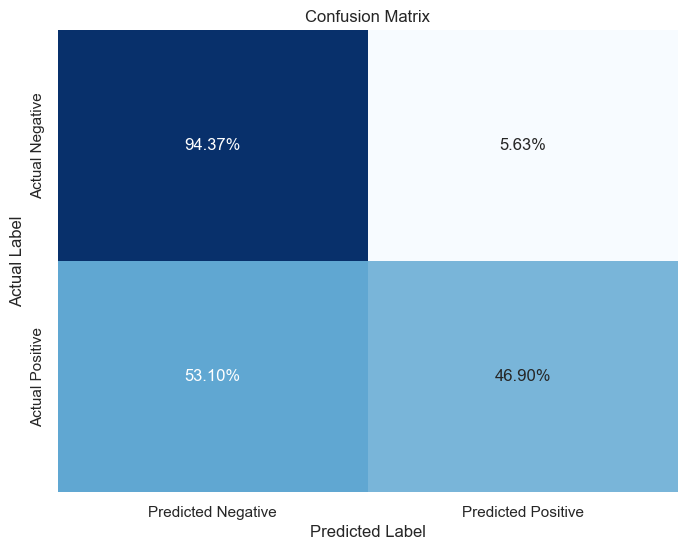

                 Predicted Negative  Predicted Positive
Actual Negative               27231                1626
Actual Positive                4384                3872
Precision: 0.7042560931247727 recall: 0.4689922480620155


In [89]:
cm = confusion_matrix(y_test, y_pred_rf)
class_totals = cm.sum(axis=1, keepdims=True)


normalized_cm = cm / class_totals


df_confusion_matrix = pd.DataFrame(normalized_cm, columns=['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive'])


plt.figure(figsize=(8, 6))
sns.heatmap(df_confusion_matrix, annot=True, cmap='Blues', fmt='.2%', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()
df_cm = pd.DataFrame(cm, index=['Actual Negative','Actual Positive'], columns=['Predicted Negative','Predicted Positive'])
print(df_cm)


true_positive = df_cm.at['Actual Positive', 'Predicted Positive']
false_positive = df_cm.at['Actual Negative', 'Predicted Positive']
false_negative = df_cm.at['Actual Positive', 'Predicted Negative']

precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)

print('Precision:',precision,'recall:',recall)

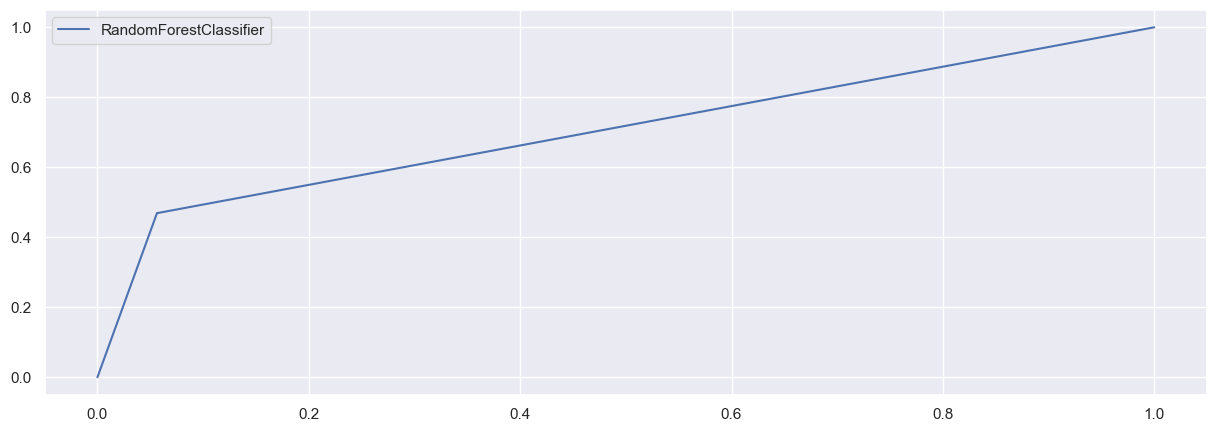

auc: 0.7063227172319642


In [90]:
auc_rf = roc_auc_score(y_test,y_pred_rf)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_rf)
plt.plot(fpr, tpr,label='RandomForestClassifier')
plt.legend()
plt.show()
print('auc:',auc_rf)

随机森林的结果不太理想，简单机器学习模型的上限大概就在model2的水平，接下去尝试深度学习模型。

## DL方法建立Classifier

In [91]:
X_train_std,X_val,y_train,y_val = train_test_split(X_train_rfe,y_train,test_size=0.2,random_state=42)

In [92]:
model_nn2 = tf.keras.Sequential()
model_nn2.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02)))  
#model_nn2.add(tf.keras.layers.Dropout(0.1))
model_nn2.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02)))  
#model_nn2.add(tf.keras.layers.Dropout(0.1))
model_nn2.add(tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02)))  
model_nn2.add(tf.keras.layers.Dense(1, activation='sigmoid'))  

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

'''def weighted_loss(y_test, y_pred):
    y_test = tf.cast(y_test, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    loss = tf.nn.weighted_cross_entropy_with_logits(labels = y_test, logits = y_pred, pos_weight=20
                                                    )
    return tf.reduce_mean(loss)
    '''
weight = 5
class_weight = {0: 1, 1:weight}

model_nn2.compile(optimizer=optimizer,  
              metrics=['binary_accuracy'],
              loss='binary_crossentropy'
              )
early_stopping = tf.keras.callbacks.EarlyStopping(patience=12, restore_best_weights=True)

trainn = model_nn2.fit(X_train_std, y_train,
                       epochs=120,
                       validation_data=(X_val, y_val),
                       callbacks=[early_stopping],
                       class_weight = class_weight)

loss, accuracy = model_nn2.evaluate(X_test_rfe,y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)
y_pred_nn2 = np.round(model_nn2.predict(X_test_rfe))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_nn2)
auc = roc_auc_score(y_test, y_pred_nn2)
print('auc:',auc)
print('recall',recall_score(y_test, y_pred_nn2))

Epoch 1/120
2165/2165 [==============================] - 6s 2ms/step - loss: 1.0750 - binary_accuracy: 0.7327 - val_loss: 0.5315 - val_binary_accuracy: 0.7886
Epoch 2/120
2165/2165 [==============================] - 4s 2ms/step - loss: 0.9328 - binary_accuracy: 0.7425 - val_loss: 0.5830 - val_binary_accuracy: 0.7438
Epoch 3/120
2165/2165 [==============================] - 3s 1ms/step - loss: 0.9217 - binary_accuracy: 0.7432 - val_loss: 0.5493 - val_binary_accuracy: 0.7628
Epoch 4/120
2165/2165 [==============================] - 3s 1ms/step - loss: 0.9174 - binary_accuracy: 0.7433 - val_loss: 0.6207 - val_binary_accuracy: 0.7165
Epoch 5/120
2165/2165 [==============================] - 3s 1ms/step - loss: 0.9142 - binary_accuracy: 0.7439 - val_loss: 0.5712 - val_binary_accuracy: 0.7482
Epoch 6/120
2165/2165 [==============================] - 3s 2ms/step - loss: 0.9118 - binary_accuracy: 0.7437 - val_loss: 0.5553 - val_binary_accuracy: 0.7544
Epoch 7/120
2165/2165 [=======================

In [93]:
model_nn2.save('model_nn.h5')

Text(0.5, 1.0, 'Confusion Matrix-FNN Model(Accuracy=0.78)')

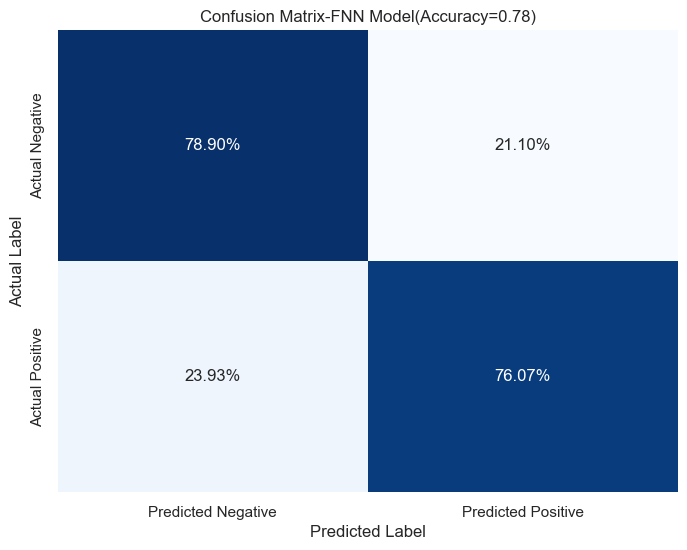

In [94]:
cm = confusion_matrix(y_test, y_pred_nn2)
class_totals = cm.sum(axis=1, keepdims=True)

normalized_cm = cm / class_totals

df_confusion_matrix = pd.DataFrame(normalized_cm, columns=['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive'])


plt.figure(figsize=(8, 6))
sns.heatmap(df_confusion_matrix, annot=True, cmap='Blues', fmt='.2%', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix-FNN Model(Accuracy={:.2f})'.format(accuracy))

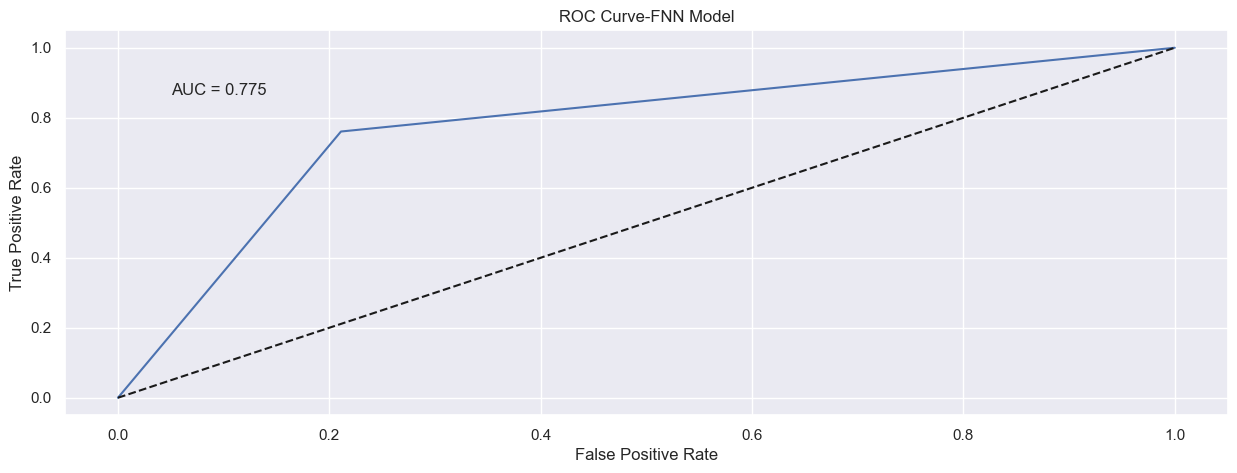

In [95]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_nn2)
auc_nn = roc_auc_score(y_test, y_pred_nn2)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')
plt.text(0.05, 0.9, 'AUC = {:.3f}'.format(auc_nn), fontsize=12,va='top')
plt.title('ROC Curve-FNN Model')
plt.show()

适当调参后，auc相对于model2，也就是逻辑回归模型有小幅度提升。

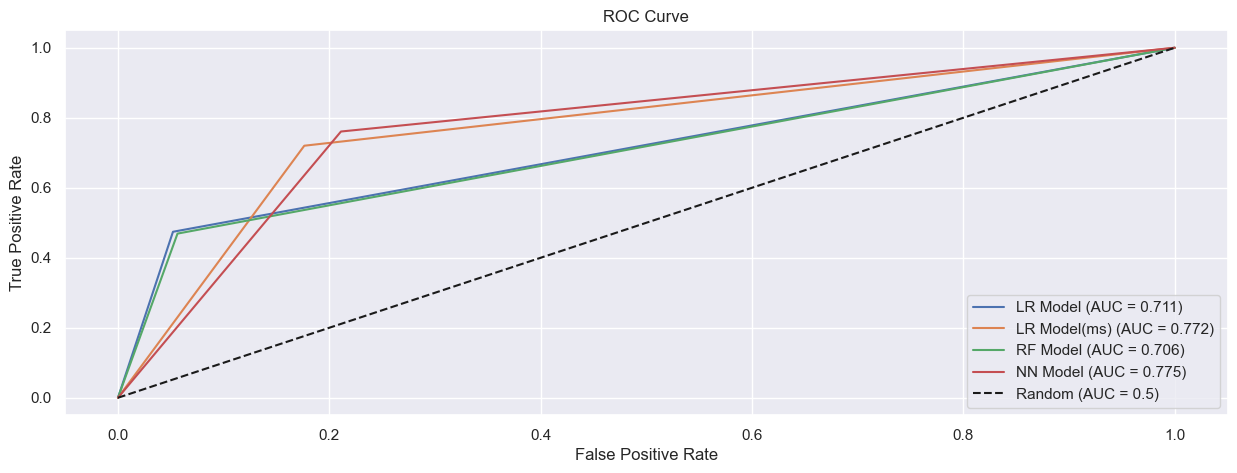

In [96]:
##将四个模型的ROC曲线放在同一坐标系内比较
fpr_1, tpr_1, _ = roc_curve(y_test, y_pred_1)
fpr_2, tpr_2, _ = roc_curve(y_test, y_pred_2)
fpr_3, tpr_3, _ = roc_curve(y_test, y_pred_rf)
fpr_4, tpr_4, _ = roc_curve(y_test, y_pred_nn2)

auc_1 = roc_auc_score(y_test, y_pred_1)
auc_2 = roc_auc_score(y_test, y_pred_2)
auc_3 = roc_auc_score(y_test, y_pred_rf)
auc_4 = roc_auc_score(y_test, y_pred_nn2)

plt.plot(fpr_1, tpr_1, label='LR Model (AUC = {:.3f})'.format(auc_1))
plt.plot(fpr_2, tpr_2, label='LR Model(ms) (AUC = {:.3f})'.format(auc_2))
plt.plot(fpr_3, tpr_3, label='RF Model (AUC = {:.3f})'.format(auc_3))
plt.plot(fpr_4, tpr_4, label='NN Model (AUC = {:.3f})'.format(auc_4))
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

plt.show()

---

# 总结

本报告大致分为三个部分：
1. 第一部分基于原始数据，先进行了缺失值处理和部分字符串编码的工作，兼顾了数据的可处理性和现实意义。在此基础上，用箱线图、累积分布图、直方图等多种图表对天气属性进行描述性统计分析；并运用热力图和时序相关性进一步刻画不同变量之间的联系；最后比较Tsne和PCA的降维方法，选择最适宜方法并使用KMEANS聚类，得到地区的更细致分类，进行更深层次的分析。
2. 第二部分主要围绕回答了时间序列意义上预测降雨的问题。首先基于第1部分的结论和热力图corrplot图表分析得出了数据之间的联系和信息。在此基础上，运用了SARIMA模型，其中设计了ACF、PACF检验以及Dickey-Fuller单位根检验等多重检验和分析，使得预测模型更加合理。最后比较了实际观测数据和one-step forecast结果的相似性，检验了所用模型的有效性。
3. 第三部分主要进一步使用ML和DL模型回答了降雨预测的二分类问题。首先比较了Tsne、MDS等多种降维方法并选择了最适宜的降维方法。在此基础上，进一步使用ML模型来检验分类效果。其中包含logistic回归、随机森林模型以及它们的优化等。最后，基于数据集较大的性质，搭建了DL模型进一步探索二分类问题的最佳选择，并绘制roc曲线比较各个模型的好坏。